In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle5
import pickle

import numpy as np
from PIL import Image
import cv2
import imageio

In [3]:
import argparse
import yaml
import torch
import os
from torch.utils.data import DataLoader

/home/burkuc/.conda/envs/etor2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import seaborn as sns

In [5]:
import utils2 as ut
import training as tr
import init_training
import model as m
import local_datasets



In [6]:
import dynaphos
from dynaphos.cortex_models import get_visual_field_coordinates_probabilistically
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs

In [7]:
directory="/home/burkuc/data/v_dy/"

In [8]:
CNN_UNCONS=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_nomax_out3_uncons_s"+str(i)
    CNN_UNCONS.append(run)

RNN_UNCONS=[]
RNN_UNCONS.append("kitty_zhao_sig_fps10_rnn_nomax_out3_uncons")
for i in range(1,5):
    run="kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s"+str(i) #redo
    RNN_UNCONS.append(run)

CNN_CONS_ONFR2=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s"+str(i)
    CNN_CONS_ONFR2.append(run)

RNN_CONS_ONFR2=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_allcons2onfr_coef2_s"+str(i)
    RNN_CONS_ONFR2.append(run)

CNN_CONS1_AMP=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_nomax_2fx_consamp_s"+str(i)
    CNN_CONS1_AMP.append(run)

RNN_CONS1_AMP=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_sliding_rnn_nomax_2fx_consamp_s"+str(i)
    RNN_CONS1_AMP.append(run)


CNN_CONS1_PW=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_nomax_2fx_conspw_s"+str(i)
    CNN_CONS1_PW.append(run)


RNN_CONS1_PW=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_sliding_rnn_nomax_2fx_conspw_s"+str(i)
    RNN_CONS1_PW.append(run)


CNN_CONS1_FREQ=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_nomax_2fx_consfreq_s"+str(i)
    CNN_CONS1_FREQ.append(run)

RNN_CONS1_FREQ=[]
for i in range(5):
    run="kitty_zhao_sig_fps10_sliding_rnn_nomax_2fx_consfreq_s"+str(i)
    RNN_CONS1_FREQ.append(run)



In [9]:

exp_dir={}

exp_dir['CNN_UNCONS']=CNN_UNCONS
exp_dir['RNN_UNCONS']=RNN_UNCONS

exp_dir['CNN_CONS_ONFR2']=CNN_CONS_ONFR2
exp_dir['RNN_CONS_ONFR2']=RNN_CONS_ONFR2

exp_dir['CNN_CONS1_AMP']=CNN_CONS1_AMP
exp_dir['RNN_CONS1_AMP']=RNN_CONS1_AMP

exp_dir['CNN_CONS1_PW']=CNN_CONS1_PW
exp_dir['RNN_CONS1_PW']=RNN_CONS1_PW

exp_dir['CNN_CONS1_FREQ']=CNN_CONS1_FREQ
exp_dir['RNN_CONS1_FREQ']=RNN_CONS1_FREQ





In [10]:
exp_dir_uncons={}
exp_dir_cons_onfr2={}
exp_dir_1cons_amp={}
exp_dir_1cons_pw={}
exp_dir_1cons_freq={}
exp_dir_cnn={}
exp_dir_rnn={}

for key, value in exp_dir.items():
    if "UNCONS" in key:
        exp_dir_uncons[key]=value
    elif "CONS_ONFR2" in key:
        exp_dir_cons_onfr2[key]=value
    elif "CONS1_AMP" in key:
        exp_dir_1cons_amp[key]=value
    elif "CONS1_PW" in key:
        exp_dir_1cons_pw[key]=value
    elif "CONS1_FREQ" in key:
        exp_dir_1cons_freq[key]=value
    elif "CNN" in key:
        exp_dir_cnn[key]=value
    elif "RNN" in key:
        exp_dir_rnn[key]=value


In [11]:
def gather_data(directory, exp_dir):
    df_train_all=pd.DataFrame()
    df_val_all=pd.DataFrame()

    dict_exps = {}
    dict_runs = {}
    for exp_name, exp_directories in exp_dir.items():
        print('exp_name', exp_name, 'exp_directories', exp_directories)
        df_train_exp=pd.DataFrame()
        df_val_exp=pd.DataFrame()

        
        for seed, run_dir in enumerate(exp_directories):
            print('seed', seed,"run_dir", run_dir )

            train_path =directory+run_dir+"/training_summary.csv"
            val_path = directory+run_dir+"/validation_summary.csv"

            if os.path.exists(train_path) and os.path.exists(val_path):

                df_train_sum=pd.read_csv(train_path)
                df_val_sum =pd.read_csv(val_path)

                df_train_exp[f"recon_loss_{exp_name}_s{seed}"]=df_train_sum["reconstruction_loss"]
                df_val_exp[f"recon_loss_{exp_name}_s{seed}"]=df_val_sum["reconstruction_loss"]

                df_train_exp[f"reg_loss_{exp_name}_s{seed}"]=df_train_sum["regularization_loss"]
                df_val_exp[f"reg_loss_{exp_name}_s{seed}"]=df_val_sum["regularization_loss"]

                df_train_exp[f"total_loss_{exp_name}_s{seed}"]=df_train_sum["total"]
                df_val_exp[f"total_loss_{exp_name}_s{seed}"]=df_val_sum["total"]


                dict_runs[f'train_{exp_name}_{seed}']=df_train_sum
                dict_runs[f'val_{exp_name}_{seed}']=df_val_sum
            
            else:
                print('DOES NOT EXISTS:', train_path, os.path.exists(train_path), val_path, os.path.exists(val_path))
        
        dic_train_relevant_columns={key: [] for key in ["recon", "reg", "total"]}
        for col in list(df_train_exp):
            # print('col', col)
            if "recon_loss" in col:
                dic_train_relevant_columns["recon"].append(col)
            elif "reg_loss" in col:
                dic_train_relevant_columns["reg"].append(col)
            elif "total_loss" in col:
                dic_train_relevant_columns["total"].append(col)
        
        dic_val_relevant_columns={key: [] for key in ["recon", "reg", "total"]}
        for col in list(df_val_exp):
            if "recon_loss" in col:
                dic_val_relevant_columns["recon"].append(col)
            elif "reg_loss" in col:
                dic_val_relevant_columns["reg"].append(col)
            elif "total_loss" in col:
                dic_val_relevant_columns["total"].append(col)

        df_train_all[f"avg_recon_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['recon']].mean(axis=1)
        df_train_all[f"std_recon_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['recon']].sem(axis=1)

        df_val_all[f"avg_recon_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['recon']].mean(axis=1)
        df_val_all[f"std_recon_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['recon']].sem(axis=1)

        df_train_all[f"avg_reg_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['reg']].mean(axis=1)
        df_train_all[f"std_reg_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['reg']].sem(axis=1)

        df_val_all[f"avg_reg_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['reg']].mean(axis=1)
        df_val_all[f"std_reg_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['reg']].sem(axis=1)

        df_train_all[f"avg_total_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['total']].mean(axis=1)
        df_train_all[f"std_total_loss_{exp_name}"]= df_train_exp[dic_train_relevant_columns['total']].sem(axis=1)

        df_val_all[f"avg_total_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['total']].mean(axis=1)
        df_val_all[f"std_total_loss_{exp_name}"]= df_val_exp[dic_val_relevant_columns['total']].sem(axis=1)


        dict_exps[f'train_{exp_name}']=df_train_exp
        dict_exps[f'val_{exp_name}']=df_val_exp

    return df_train_all, df_val_all, dict_exps, dict_runs

In [12]:
df_train_all, df_val_all, dict_exps, dict_runs = gather_data(directory, exp_dir)


exp_name CNN_UNCONS exp_directories ['kitty_zhao_sig_fps10_nomax_out3_uncons_s0', 'kitty_zhao_sig_fps10_nomax_out3_uncons_s1', 'kitty_zhao_sig_fps10_nomax_out3_uncons_s2', 'kitty_zhao_sig_fps10_nomax_out3_uncons_s3', 'kitty_zhao_sig_fps10_nomax_out3_uncons_s4']
seed 0 run_dir kitty_zhao_sig_fps10_nomax_out3_uncons_s0
seed 1 run_dir kitty_zhao_sig_fps10_nomax_out3_uncons_s1
seed 2 run_dir kitty_zhao_sig_fps10_nomax_out3_uncons_s2
DOES NOT EXISTS: /home/burkuc/data/v_dy/kitty_zhao_sig_fps10_nomax_out3_uncons_s2/training_summary.csv False /home/burkuc/data/v_dy/kitty_zhao_sig_fps10_nomax_out3_uncons_s2/validation_summary.csv False
seed 3 run_dir kitty_zhao_sig_fps10_nomax_out3_uncons_s3
seed 4 run_dir kitty_zhao_sig_fps10_nomax_out3_uncons_s4
exp_name RNN_UNCONS exp_directories ['kitty_zhao_sig_fps10_rnn_nomax_out3_uncons', 'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s1', 'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s2', 'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s

In [17]:
list(df_train_all)

['avg_recon_loss_CNN_UNCONS',
 'std_recon_loss_CNN_UNCONS',
 'avg_reg_loss_CNN_UNCONS',
 'std_reg_loss_CNN_UNCONS',
 'avg_total_loss_CNN_UNCONS',
 'std_total_loss_CNN_UNCONS',
 'avg_recon_loss_RNN_UNCONS',
 'std_recon_loss_RNN_UNCONS',
 'avg_reg_loss_RNN_UNCONS',
 'std_reg_loss_RNN_UNCONS',
 'avg_total_loss_RNN_UNCONS',
 'std_total_loss_RNN_UNCONS',
 'avg_recon_loss_CNN_CONS_ONFR2',
 'std_recon_loss_CNN_CONS_ONFR2',
 'avg_reg_loss_CNN_CONS_ONFR2',
 'std_reg_loss_CNN_CONS_ONFR2',
 'avg_total_loss_CNN_CONS_ONFR2',
 'std_total_loss_CNN_CONS_ONFR2',
 'avg_recon_loss_RNN_CONS_ONFR2',
 'std_recon_loss_RNN_CONS_ONFR2',
 'avg_reg_loss_RNN_CONS_ONFR2',
 'std_reg_loss_RNN_CONS_ONFR2',
 'avg_total_loss_RNN_CONS_ONFR2',
 'std_total_loss_RNN_CONS_ONFR2',
 'avg_recon_loss_CNN_CONS1_AMP',
 'std_recon_loss_CNN_CONS1_AMP',
 'avg_reg_loss_CNN_CONS1_AMP',
 'std_reg_loss_CNN_CONS1_AMP',
 'avg_total_loss_CNN_CONS1_AMP',
 'std_total_loss_CNN_CONS1_AMP',
 'avg_recon_loss_RNN_CONS1_AMP',
 'std_recon_loss_RNN_

In [12]:
exp_dir.keys()

dict_keys(['CNN_UNCONS', 'RNN_UNCONS', 'CNN_CONS_ONFR2', 'RNN_CONS_ONFR2', 'CNN_CONS1_AMP', 'RNN_CONS1_AMP', 'CNN_CONS1_PW', 'RNN_CONS1_PW', 'CNN_CONS1_FREQ', 'RNN_CONS1_FREQ'])

In [13]:
def plot_across_experiments_total(exp_dir, df_train_all, df_val_all, total=True, recon=False, regul=False):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6),dpi=120)
    for exp in exp_dir.keys():

        x=df_train_all.index

        if total:
            ax1.plot(df_train_all["avg_total_loss_"+exp], label="tr_total_loss_"+exp)#, color='tab:purple')
            ax1.fill_between(df_train_all["avg_total_loss_"+exp]-df_train_all["std_total_loss_"+exp], df_train_all["avg_total_loss_"+exp]+df_train_all["std_total_loss_"+exp], alpha=0.35, label="tr_total_loss_SEM_"+exp)#, color='tab:purple')
            
            ax2.plot(df_val_all["avg_total_loss_"+exp], label="val_total_loss_"+exp)#, ls='--', color='tab:purple')
            ax2.fill_between(df_val_all["avg_total_loss_"+exp]-df_val_all["std_total_loss_"+exp], df_val_all["avg_total_loss_"+exp]+df_val_all["std_total_loss_"+exp], alpha=0.35, label="val_total_loss_SEM_"+exp)#, color='tab:purple')

        if recon:
            ax1.plot(df_train_all["avg_recon_loss_"+exp],label="tr_recon_loss_"+exp)#, color='tab:red' )
            ax1.fill_between(df_train_all["avg_recon_loss_"+exp]-df_train_all["std_recon_loss_"+exp], df_train_all["avg_recon_loss_"+exp]+df_train_all["std_recon_loss_"+exp], alpha=0.35, label="tr_recon_loss_SEM_"+exp)#, color='tab:red')

            ax2.plot(df_val_all["avg_recon_loss_"+exp],label="val_recon_loss_"+exp)#, ls='--', color='tab:red')
            ax2.fill_between(df_val_all["avg_recon_loss_"+exp]-df_val_all["std_recon_loss_"+exp], df_val_all["avg_recon_loss_"+exp]+df_val_all["std_recon_loss_"+exp], alpha=0.35, label="val_recon_loss_SEM_"+exp)#, color='tab:red')


        if regul:
            ax1.plot(df_train_all["avg_reg_loss_"+exp], label="tr_reg_loss_"+exp)#, color='tab:blue')
            ax1.fill_between(df_train_all["avg_reg_loss_"+exp]-df_train_all["std_total_loss_"+exp], df_train_all["avg_reg_loss_"+exp]+df_train_all["std_total_loss_"+exp], alpha=0.35, label="tr_reg_loss_SEM_"+exp)#, color='tab:blue')
            
            ax2.plot(df_val_all["avg_reg_loss_"+exp], label="val_reg_loss_"+exp)#, ls='--', color='tab:blue')
            ax2.fill_between(df_val_all["avg_reg_loss_"+exp]-df_val_all["std_total_loss_"+exp], df_val_all["avg_reg_loss_"+exp]+df_val_all["std_total_loss_"+exp], alpha=0.35, label="val_reg_loss_SEM_"+exp)#, color='tab:blue')
        

        # ax1.legend()
        # ax2.legend()
        fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.show()

In [14]:
dict_runs

{'train_CNN_UNCONS_0':      timestamp     epochs  samples     total  reconstruction_loss  \
 0     E00-B070   0.016659      140  0.259616             0.068832   
 1     E00-B140   0.033317      280  0.246249             0.063334   
 2     E00-B210   0.049976      420  0.243964             0.058891   
 3     E00-B280   0.066635      560  0.244353             0.059600   
 4     E00-B350   0.083294      700  0.244193             0.053905   
 ..         ...        ...      ...       ...                  ...   
 676  E11-B1190  11.283198    94824  0.051896             0.017882   
 677  E11-B1260  11.299857    94964  0.051784             0.017478   
 678  E11-B1330  11.316516    95104  0.050831             0.016914   
 679  E11-B1400  11.333175    95244  0.052753             0.018914   
 680  E11-B1470  11.349833    95384  0.051711             0.017841   
 
      regularization_loss     label  
 0               0.450400  training  
 1               0.429164  training  
 2               0.429

In [12]:
def plot_within_experiment2(dict_runs, dict_exps):

    for k, key in enumerate(dict_runs):
        
        if "train" in key:
            train = dict_runs[key]

        elif "val" in key:
            val = dict_runs[key]

        if k%2==1:
            
            # fig, (ax, ax3) = plt.subplots(1,2, figsize=(20,6),dpi=120)
            fig, ax = plt.subplots(1,1) #, figsize=(10,6),dpi=120)
            ax2 = ax.twinx()

            ax.plot(train['epochs'], train["total"], label="tr. total loss")
            ax.plot(train['epochs'],train["reconstruction_loss"], label="tr. reconstruction loss")# + key.split("s")[-1])
            ax.plot(train['epochs'], train["regularization_loss"], label="tr. regularizations loss")# + key.split("s")[-1])

            ax2.plot(val['epochs'],val["total"], ls="--", label="val. total loss")#+ key.split("s")[-1])
            ax2.plot(val['epochs'],val["reconstruction_loss"], ls="--", label="val. reconstruction loss")# + key.split("s")[-1])
            ax2.plot(val['epochs'],val["regularization_loss"], ls="--", label="val. regularization loss")# + key.split("s")[-1])

            #FOR NORMALIZING REG LOSS 
            # ax4 = ax3.twinx()
            # print(train["regularization_loss"].min(), train["regularization_loss"].max())
            # print(val["regularization_loss"].min(), val["regularization_loss"].max())
            # reg_loss_train_normalized = (train["regularization_loss"]-train["regularization_loss"].min())/(train["regularization_loss"].max()-train["regularization_loss"].min())
            # reg_loss_val_normalized = (val["regularization_loss"]-val["regularization_loss"].min())/(val["regularization_loss"].max()-val["regularization_loss"].min())
            # ax3.plot(train["epochs"], reg_loss_train_normalized, label="tr. reg. loss " + key.split("s")[-1])
            # ax4.plot(val["epochs"], reg_loss_val_normalized, ls="--", label="val. reg. loss " + key.split("s")[-1])
            

            fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('epochs')
            plt.title(f'{key.split("_")[1]}_{key.split("_")[2]} - Seed {key.split("_")[-1]}')
            

            plt.show()


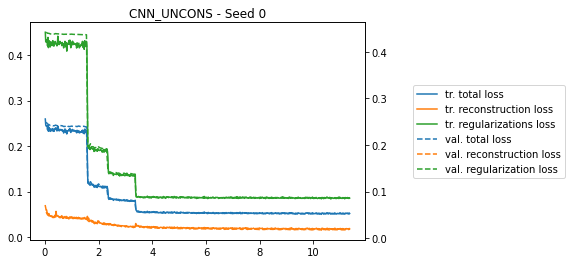

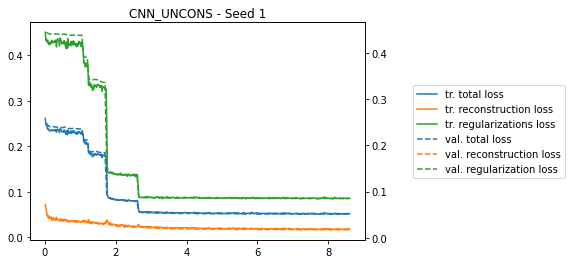

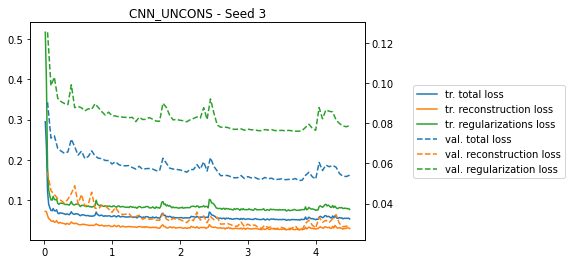

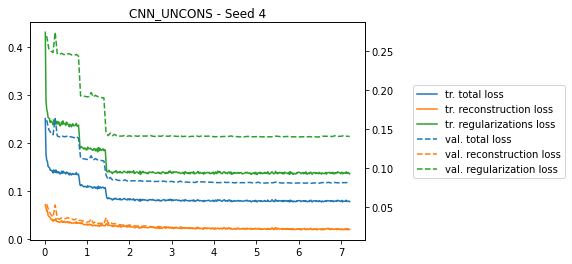

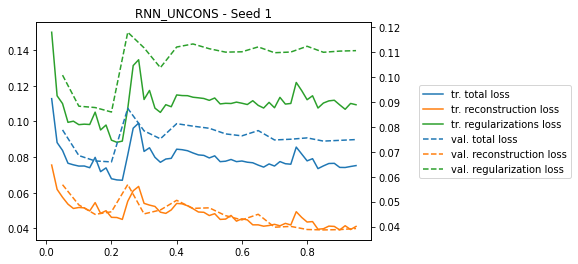

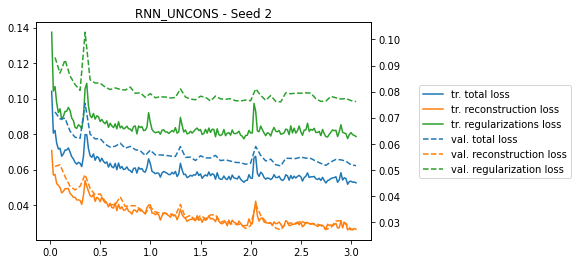

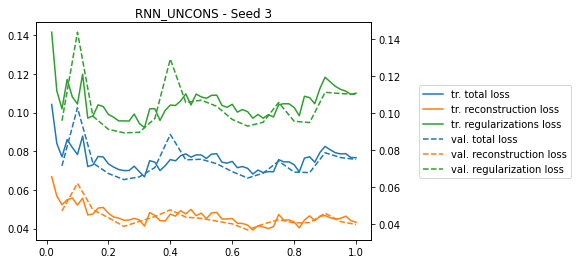

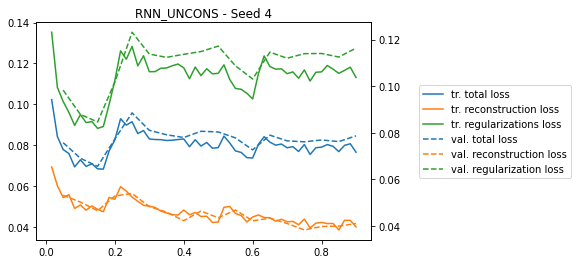

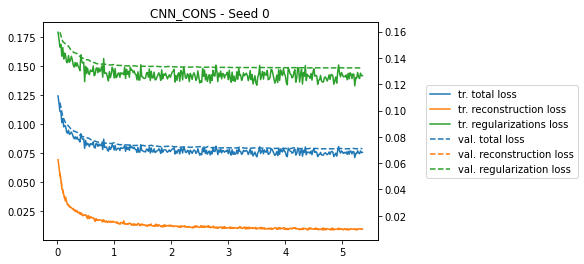

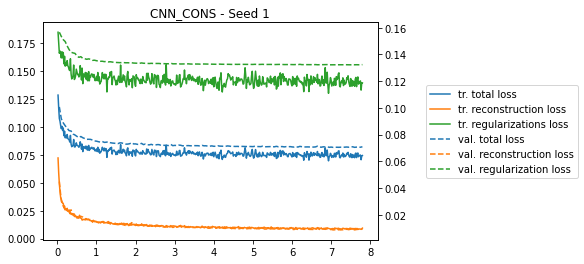

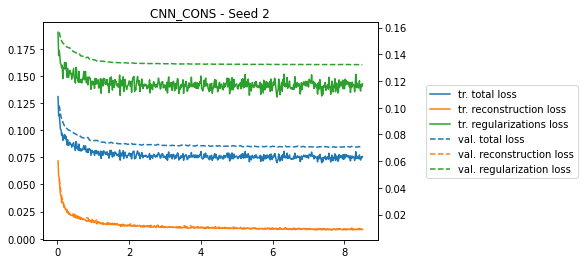

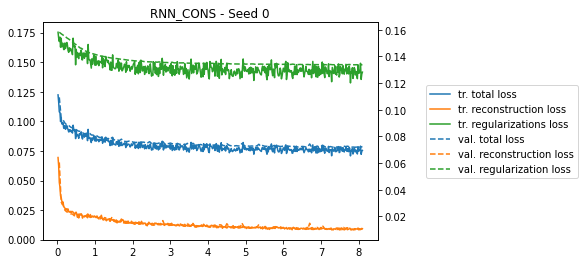

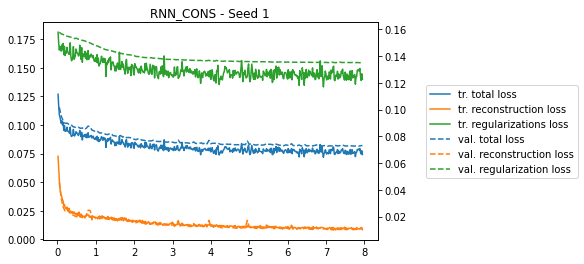

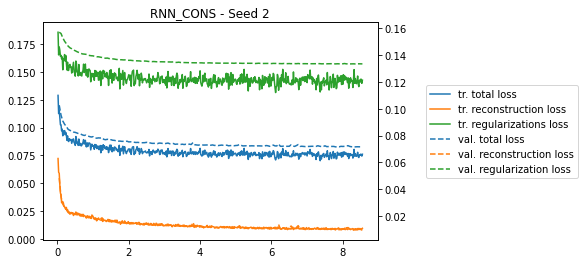

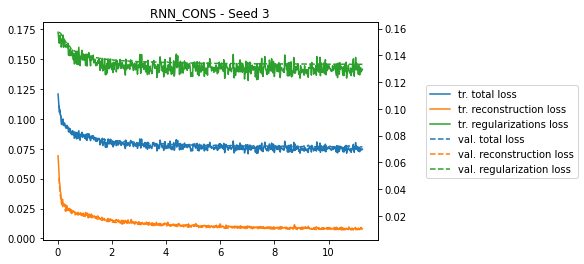

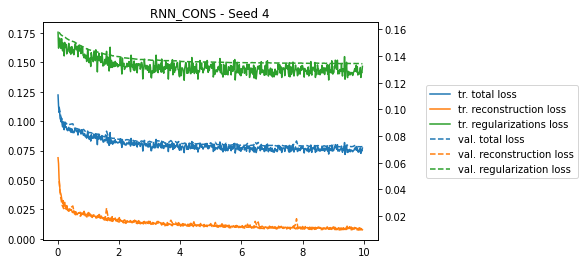

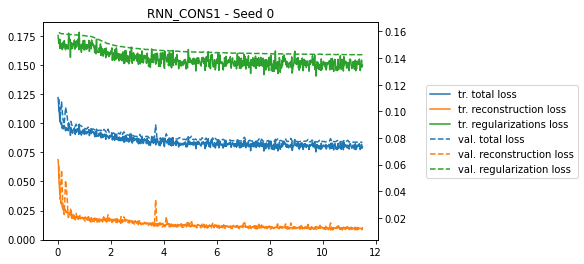

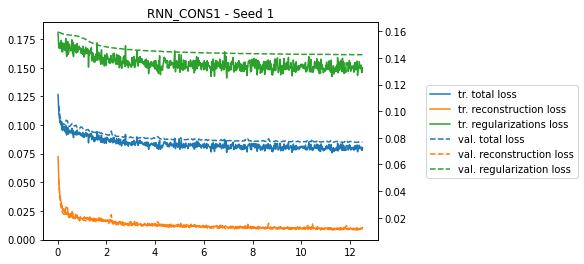

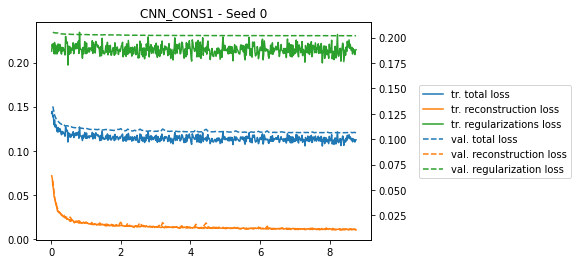

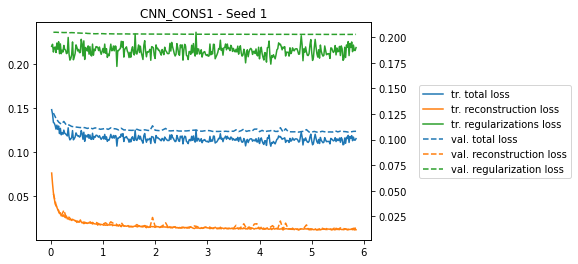

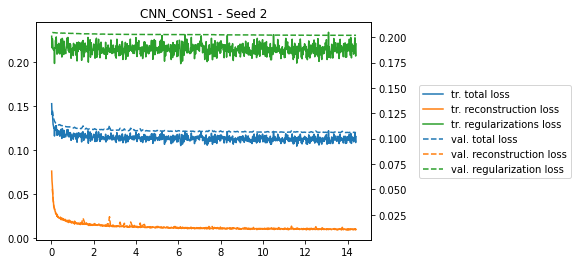

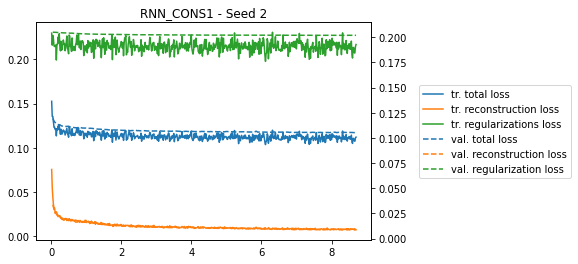

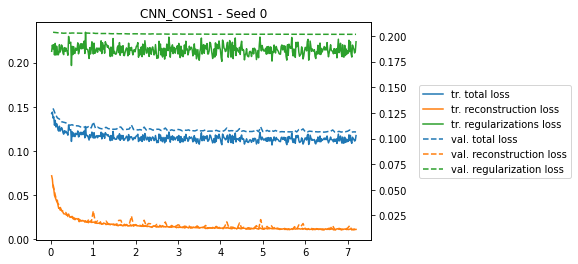

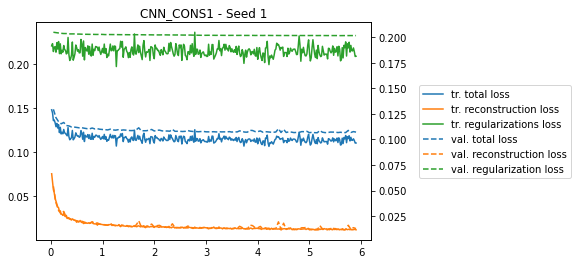

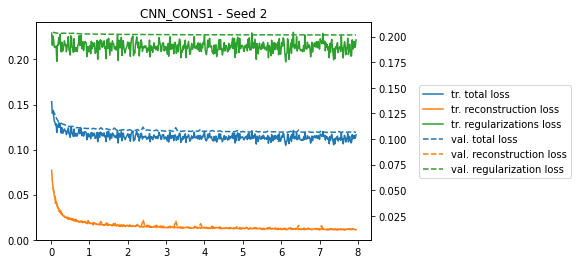

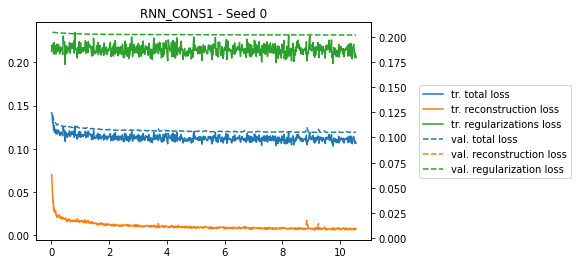

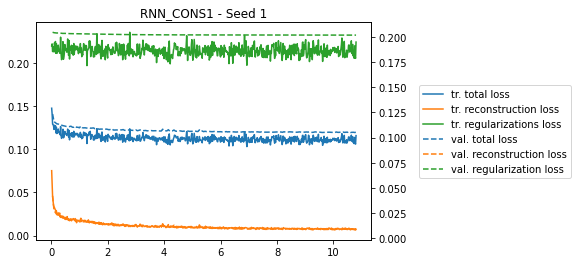

In [16]:
plot_within_experiment2(dict_runs, dict_exps)

In [13]:
def plot_across_experiment_seeds(dict_runs, dict_exps, exp_name):

    train_total=[]
    val_total=[]
    train_recon=[]
    val_recon=[]
    train_reg=[]
    val_reg=[]

    for exp_key, exp_data_dict in dict_exps.items():
        

        if exp_name in exp_key:
            print(exp_key)
            
        
            if "train" in exp_key:
                train = exp_data_dict

                for key, value in train.items():
                    last_value=value.fillna(method='ffill').iloc[-1]
                    print(key, last_value)
                    if "total" in key:
                        train_total.append(last_value)
                    elif "recon" in key:
                        train_recon.append(last_value)
                    elif "reg" in key:
                        train_reg.append(last_value)
                    

            elif "val" in exp_key:
                val = exp_data_dict

                for key, value in val.items():
                    last_value=value.fillna(method='ffill').iloc[-1]
                    print(key, last_value)
                    if "total" in key:
                        val_total.append(last_value)
                    elif "recon" in key:
                        val_recon.append(last_value)
                    elif "reg" in key:
                        val_reg.append(last_value)


    train_total=pd.DataFrame(train_total)
    val_total=pd.DataFrame(val_total)
    train_recon=pd.DataFrame(train_recon)
    val_recon=pd.DataFrame(val_recon)
    train_reg=pd.DataFrame(train_reg)
    val_reg=pd.DataFrame(val_reg)
 
    # return data
    return train_total, val_total, train_recon, val_recon , train_reg, val_reg


In [14]:
data_cnn_uncons=plot_across_experiment_seeds(dict_runs, dict_exps, "CNN_UNCONS")
data_rnn_uncons=plot_across_experiment_seeds(dict_runs, dict_exps, "RNN_UNCONS")
data_cnn_cons_onfr2=plot_across_experiment_seeds(dict_runs, dict_exps, "CNN_CONS_ONFR2")
data_rnn_cons_onfr2=plot_across_experiment_seeds(dict_runs, dict_exps, "RNN_CONS_ONFR2")
data_cnn_cons1_amp=plot_across_experiment_seeds(dict_runs, dict_exps, "CNN_CONS1_AMP")
data_rnn_cons1_amp=plot_across_experiment_seeds(dict_runs, dict_exps, "RNN_CONS1_AMP")
data_cnn_cons1_pw=plot_across_experiment_seeds(dict_runs, dict_exps, "CNN_CONS1_PW")
data_rnn_cons1_pw=plot_across_experiment_seeds(dict_runs, dict_exps, "RNN_CONS1_PW")
data_cnn_cons1_freq=plot_across_experiment_seeds(dict_runs, dict_exps, "CNN_CONS1_FREQ")
data_rnn_cons1_freq=plot_across_experiment_seeds(dict_runs, dict_exps, "RNN_CONS1_FREQ")

train_CNN_UNCONS
recon_loss_CNN_UNCONS_s0 0.0178409668350858
reg_loss_CNN_UNCONS_s0 0.085581818648747
total_loss_CNN_UNCONS_s0 0.0517113929880516
recon_loss_CNN_UNCONS_s1 0.0180968846593584
reg_loss_CNN_UNCONS_s1 0.0855266022895063
total_loss_CNN_UNCONS_s1 0.0518117435276508
recon_loss_CNN_UNCONS_s3 0.0292015563962715
reg_loss_CNN_UNCONS_s3 0.0769995884703738
total_loss_CNN_UNCONS_s3 0.0531005723667996
recon_loss_CNN_UNCONS_s4 0.0208641188618327
reg_loss_CNN_UNCONS_s4 0.1364117770322731
total_loss_CNN_UNCONS_s4 0.0786379480468375
val_CNN_UNCONS
recon_loss_CNN_UNCONS_s0 0.0191531441627146
reg_loss_CNN_UNCONS_s0 0.0875817356866483
total_loss_CNN_UNCONS_s0 0.0533674399685553
recon_loss_CNN_UNCONS_s1 0.0181410063668383
reg_loss_CNN_UNCONS_s1 0.0859334692039888
total_loss_CNN_UNCONS_s1 0.0520372378542157
recon_loss_CNN_UNCONS_s3 0.0292292484889959
reg_loss_CNN_UNCONS_s3 0.0790348166731491
total_loss_CNN_UNCONS_s3 0.0541320327964533
recon_loss_CNN_UNCONS_s4 0.0215089607233983
reg_loss_CNN_UN

In [15]:
def boxplots_over_seeds(loss_to_plot):
    fig = plt.figure(figsize =(25, 7))
    
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    if loss_to_plot=="train_total":
        i=0
        loss_type='Total'
    elif loss_to_plot=="val_total":
        i=1
        loss_type='Total'
    elif loss_to_plot=="train_recon":
        i=2
        loss_type='Reconstruction'
    elif loss_to_plot=="val_recon":
        i=3
        loss_type='Reconstruction'
    elif loss_to_plot=="train_reg":
        i=4
        loss_type='Regularization'
    elif loss_to_plot=="val_reg":
        i=5
        loss_type='Regularization'

    if i%2==0:
        mode='Training'
    else:
        mode='Validation'


    data2=[
            data_cnn_uncons[i][0], 
            data_rnn_uncons[i][0], 
            data_cnn_cons_onfr2[i][0], 
            data_rnn_cons_onfr2[i][0], 

            # data_cnn_cons1_amp[i][0], 

            data_rnn_cons1_amp[i][0], 
            data_cnn_cons1_pw[i][0], 

            # data_rnn_cons1_pw[i][0], 

            data_cnn_cons1_freq[i][0],
            data_rnn_cons1_freq[i][0]
            ]
    # Creating plot
    bp = ax.boxplot(data2)
    ax.set_xticklabels([
                        'CNN Uncons.', 
                        'RNN Uncons.',
                        'CNN All Cons.', 
                        'RNN All Cons.',

                        # 'CNN Ampl. Cons.', 

                        'RNN Ampl. Cons.',  
                        'CNN PW Cons.', 

                        # 'RNN PW Cons.', 

                        'CNN Freq. Cons.', 
                        'RNN Freq. Cons.'
                        ])
    ax.set_title(f'Final {mode} {loss_type} Loss')
    # plt.savefig('breakout_box_maxrew')
    plt.show()

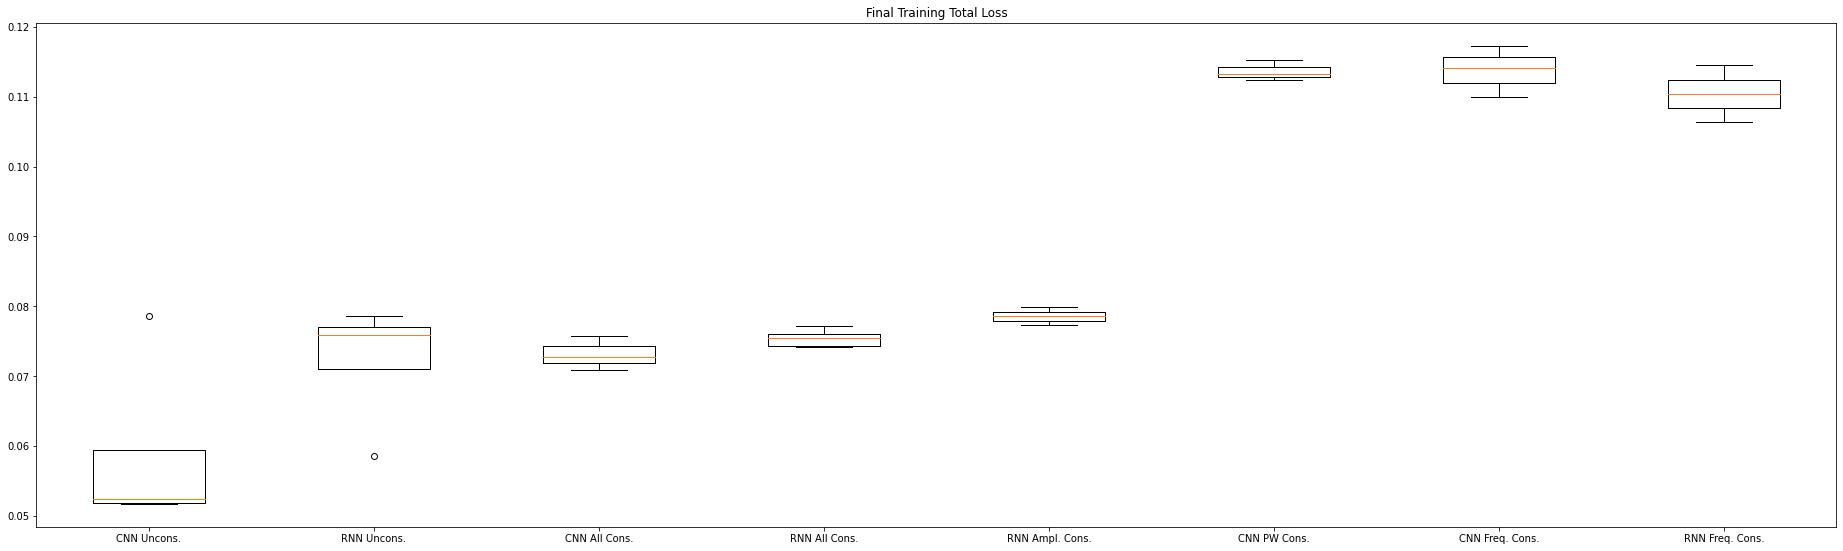

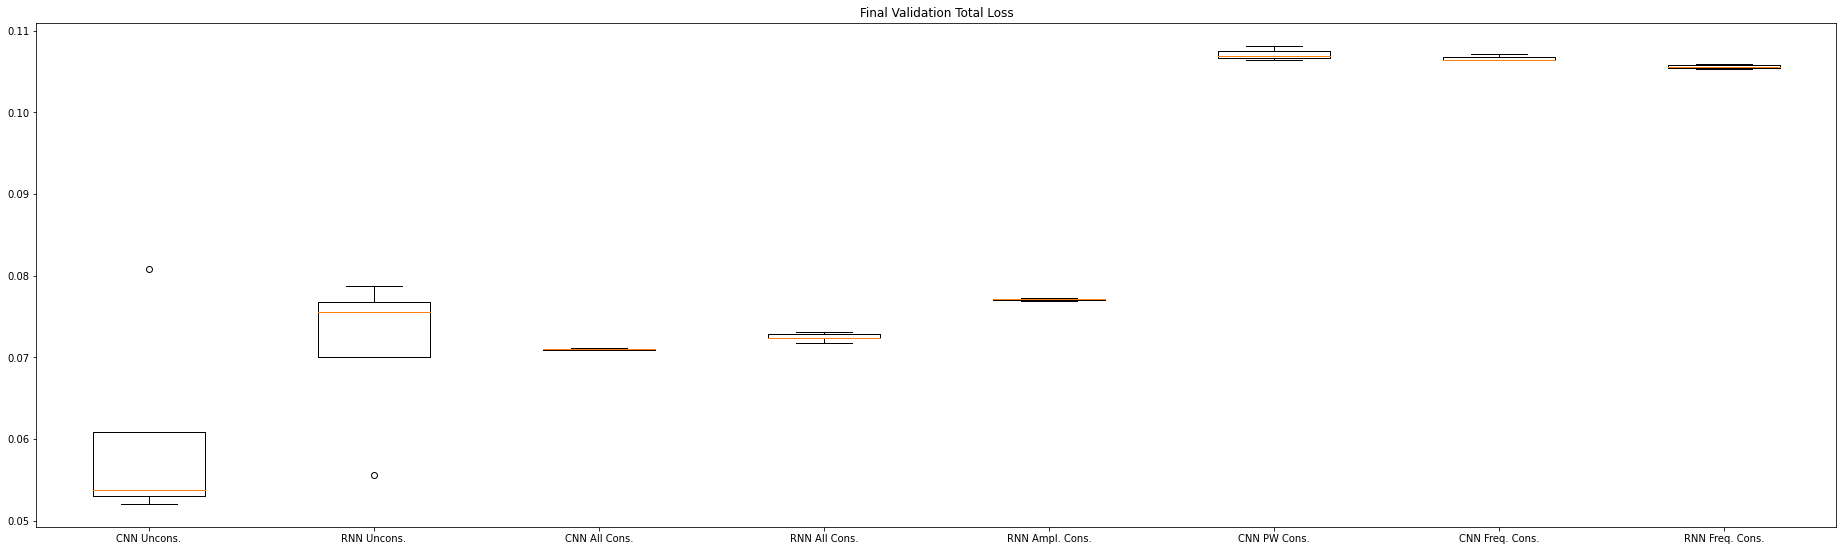

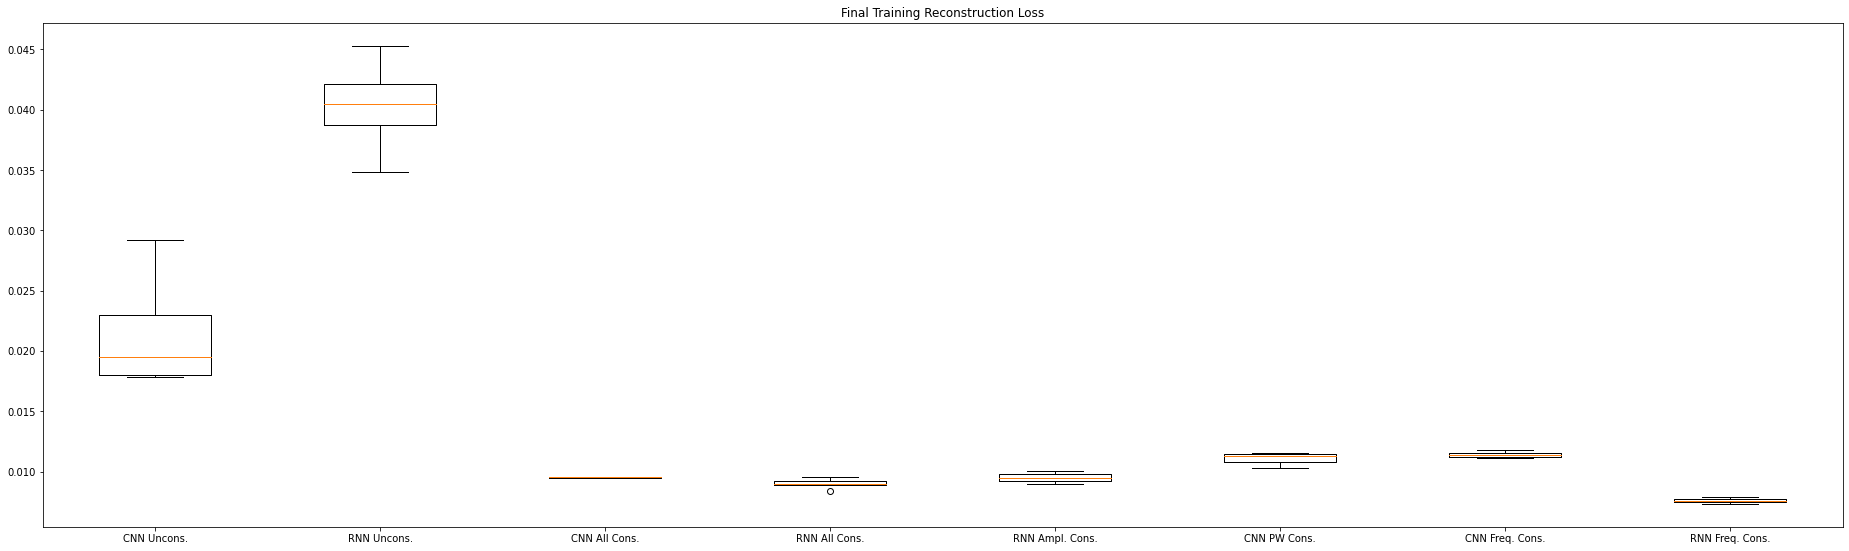

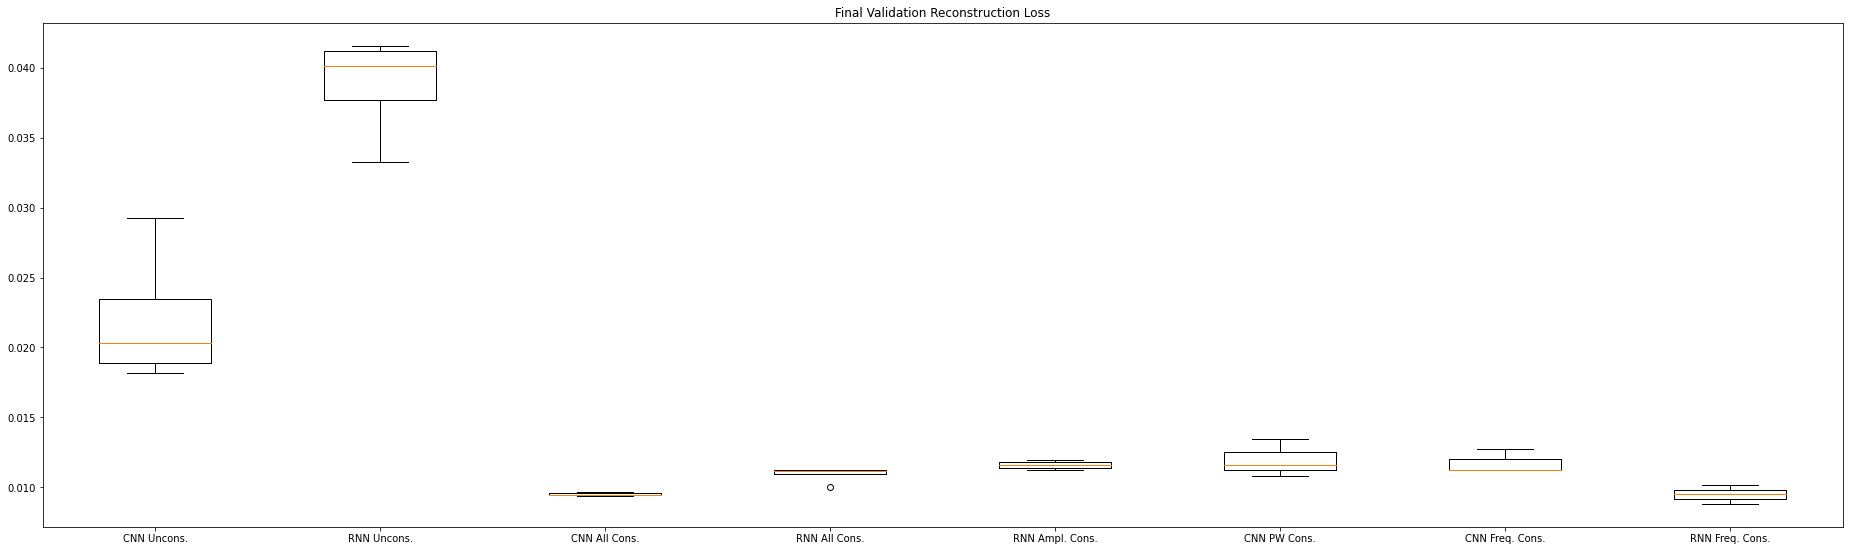

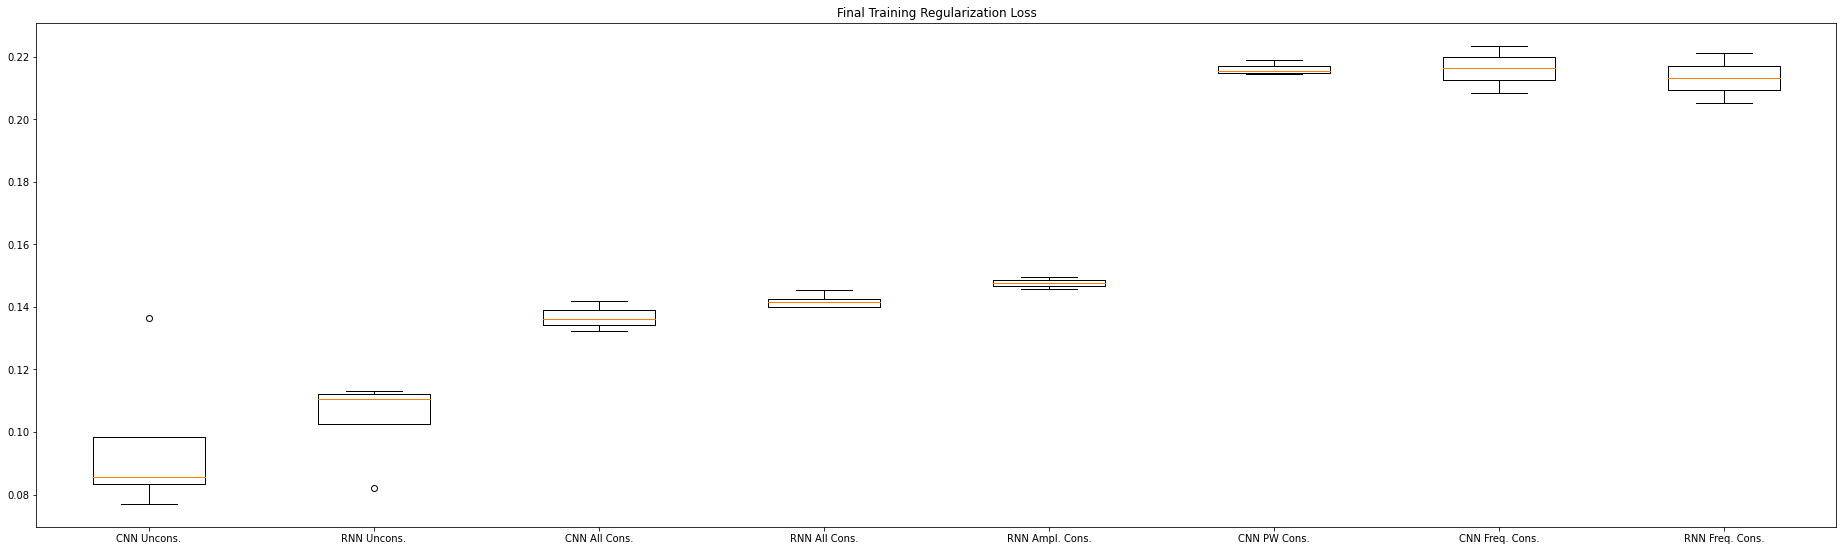

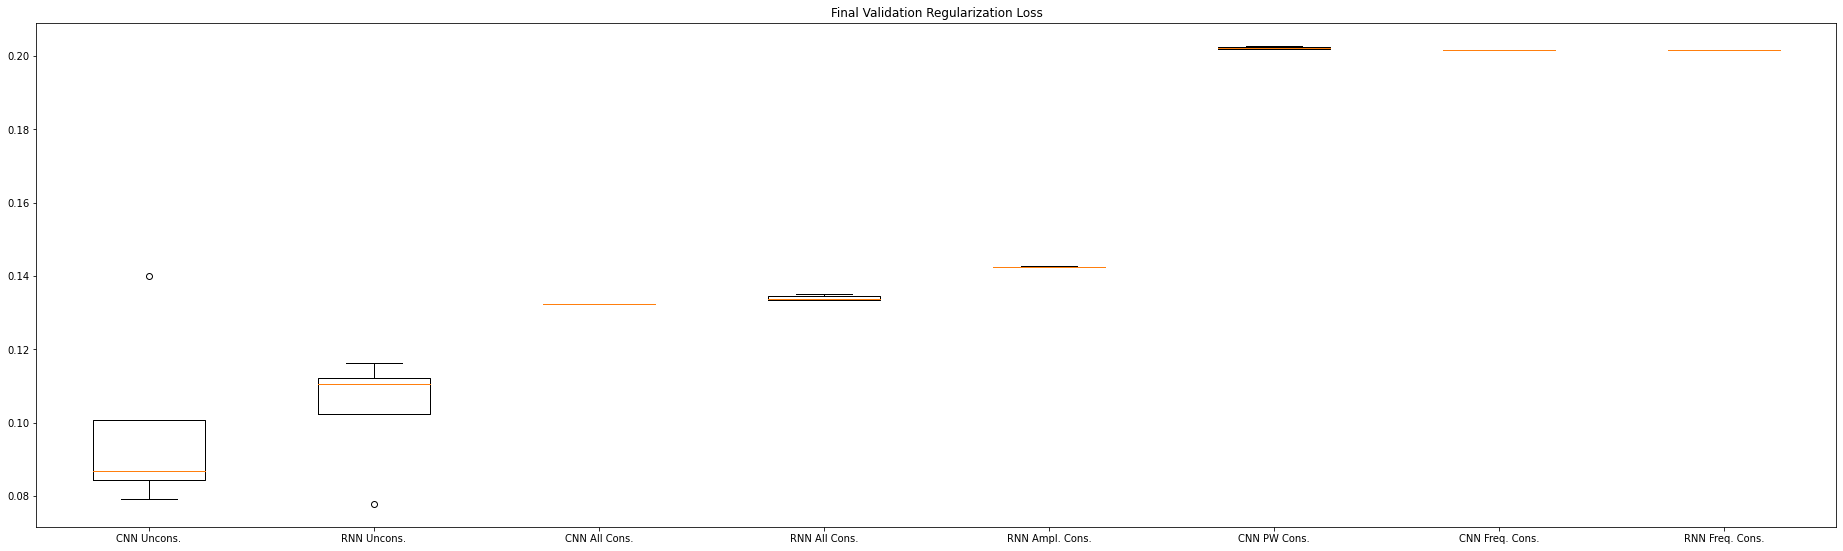

In [16]:
boxplots_over_seeds(loss_to_plot='train_total')
boxplots_over_seeds(loss_to_plot='val_total')
boxplots_over_seeds(loss_to_plot='train_recon')
boxplots_over_seeds(loss_to_plot='val_recon')
boxplots_over_seeds(loss_to_plot='train_reg')
boxplots_over_seeds(loss_to_plot='val_reg')

In [51]:
data_rnn_cons1_pw[1]

0
0  0.10542

In [17]:
def experiments_in_boxplots(loss_to_plot):
    
    if loss_to_plot=="train_total":
        i=0
        loss_type='Total'
    elif loss_to_plot=="val_total":
        i=1
        loss_type='Total'
    elif loss_to_plot=="train_recon":
        i=2
        loss_type='Reconstruction'
    elif loss_to_plot=="val_recon":
        i=3
        loss_type='Reconstruction'
    elif loss_to_plot=="train_reg":
        i=4
        loss_type='Regularization'
    elif loss_to_plot=="val_reg":
        i=5
        loss_type='Regularization'

    if i%2==0:
        mode='Training'
    else:
        mode='Validation'

    df=[]
    cnn_uncons=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'CNN': data_cnn_uncons[i][0]}) #ADD MISSING SEED #MISSING 1
    cnn_cons_all=pd.DataFrame({'Experiment':['CONS_ALL 0', 'CONS_ALL 1', 'CONS_ALL 2'], 'CNN': data_cnn_cons_onfr2[i][0]}) #ADD MISSING SEEDS! #MISSING 2
    # cnn_cons_amp=pd.DataFram  e({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3', 'CONS_AMP 4'], 'CNN': data_cnn_cons1_amp[i][0]}) #MISSING 5!!
    cnn_cons_pw=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'CNN': data_cnn_cons1_pw[i][0]}) #MISSING 2
    cnn_cons_freq=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'CNN': data_cnn_cons1_freq[i][0]}) #MISSING 2


    # print(normal_avg)
    df_cnn=pd.concat([cnn_uncons, cnn_cons_all, cnn_cons_pw, cnn_cons_freq])#, canny_avg, e2e_avg, blind_avg])
    # df_cnn=pd.concat([cnn_uncons, cnn_cons_all, cnn_cons_amp, cnn_cons_pw, cnn_cons_freq])#, canny_avg, e2e_avg, blind_avg])


    rnn_uncons=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'RNN': data_rnn_uncons[i][0]})  #ADD MISSING SEED #MISSING 1
    rnn_cons_all=pd.DataFrame({'Experiment':['CONS_ALL 0', 'CONS_ALL 1', 'CONS_ALL 2', 'CONS_ALL 3', 'CONS_ALL 4'], 'RNN': data_rnn_cons_onfr2[i][0]}) #ALL HERE
    # rnn_cons_amp=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'RNN': data_rnn_cons1_amp[1][0]}) #MISSING 3
    rnn_cons_pw=pd.DataFrame({'Experiment':['CONS_PW 0'], 'RNN': data_rnn_cons1_pw[i][0]}) #MISSING 4
    rnn_cons_freq=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'RNN': data_rnn_cons1_freq[i][0]}) #MISSING 3

    df_rnn=pd.concat([rnn_uncons, rnn_cons_all, rnn_cons_pw, rnn_cons_freq])
    # df_rnn=pd.concat([rnn_uncons, rnn_cons_all, rnn_cons_amp, rnn_cons_pw, rnn_cons_freq])


    df=df_cnn.join(df_rnn.set_index('Experiment'), on='Experiment')
    df['Experiment']=df['Experiment'].apply(lambda x: x.split(' ')[0])

    print(df)

    fig = plt.figure(figsize =(15, 7))
    dd=pd.melt(df,id_vars=['Experiment'],value_vars=['CNN','RNN'],var_name='Loss')
    sns.set_theme()#style="whitegrid")
    sns.set_context("paper", font_scale=2.5) 
    sns.boxplot(x='Experiment', y='value',data=dd,hue='Loss', width=0.6)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.title(f'Final {mode} {loss_type} Loss', fontsize=26)
    plt.legend()

    plt.legend(fontsize=19, bbox_to_anchor=(1.15, 1.0),loc='upper right')
    plt.tight_layout()

    plt.show()

   Experiment       CNN       RNN
0  UNCONS_ALL  0.051711  0.075216
1  UNCONS_ALL  0.051812  0.058520
2  UNCONS_ALL  0.053101  0.078655
3  UNCONS_ALL  0.078638  0.076539
0    CONS_ALL  0.075718  0.075429
1    CONS_ALL  0.072769  0.074190
2    CONS_ALL  0.070864  0.077103
0     CONS_PW  0.112418  0.112113
1     CONS_PW  0.115280       NaN
2     CONS_PW  0.113252       NaN
0   CONS_FREQ  0.117289  0.106315
1   CONS_FREQ  0.109935  0.114479
2   CONS_FREQ  0.114081       NaN


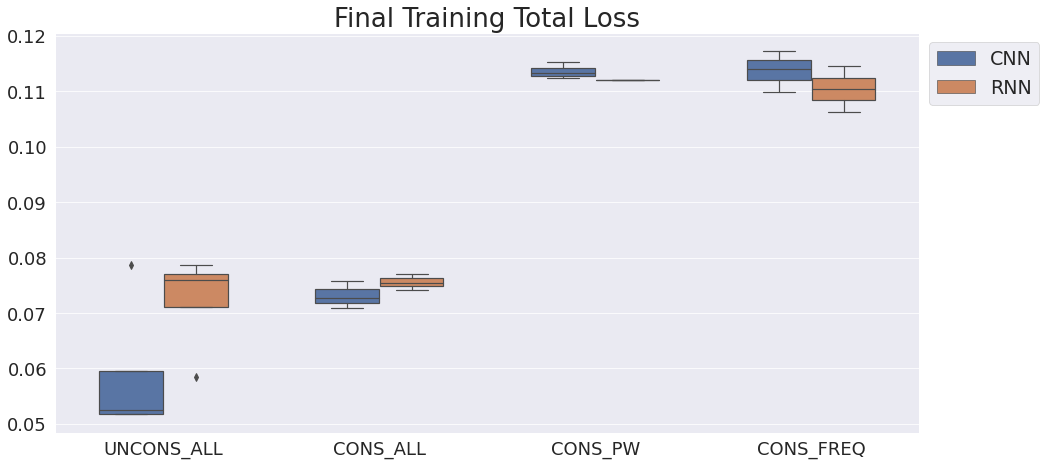

   Experiment       CNN       RNN
0  UNCONS_ALL  0.053367  0.074918
1  UNCONS_ALL  0.052037  0.055528
2  UNCONS_ALL  0.054132  0.076064
3  UNCONS_ALL  0.080750  0.078714
0    CONS_ALL  0.071082  0.072344
1    CONS_ALL  0.070920  0.073109
2    CONS_ALL  0.070960  0.072347
0     CONS_PW  0.106332  0.105420
1     CONS_PW  0.108140       NaN
2     CONS_PW  0.106925       NaN
0   CONS_FREQ  0.106432  0.105291
1   CONS_FREQ  0.107179  0.105892
2   CONS_FREQ  0.106384       NaN


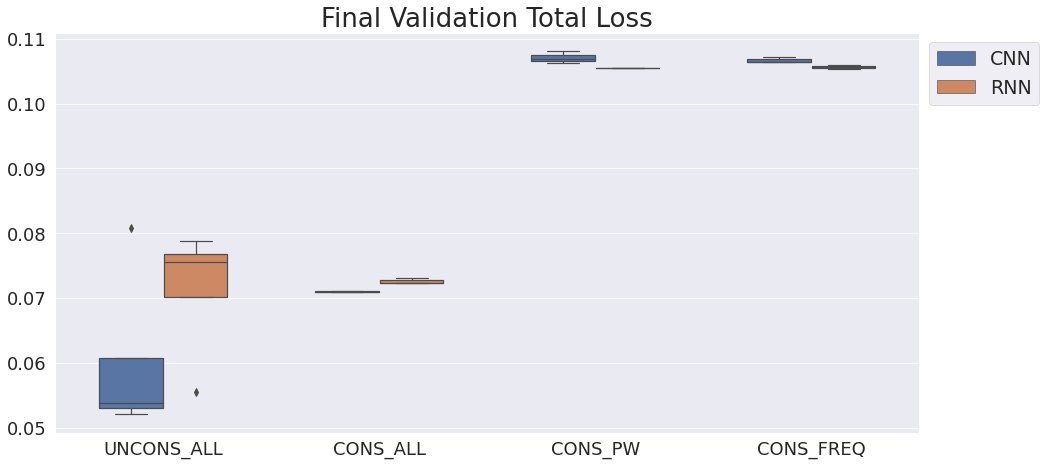

   Experiment       CNN       RNN
0  UNCONS_ALL  0.017841  0.041055
1  UNCONS_ALL  0.018097  0.034885
2  UNCONS_ALL  0.029202  0.045314
3  UNCONS_ALL  0.020864  0.039973
0    CONS_ALL  0.009481  0.009248
1    CONS_ALL  0.009564  0.008379
2    CONS_ALL  0.009530  0.008942
0     CONS_PW  0.010268  0.007587
1     CONS_PW  0.011590       NaN
2     CONS_PW  0.011264       NaN
0   CONS_FREQ  0.011107  0.007331
1   CONS_FREQ  0.011400  0.007892
2   CONS_FREQ  0.011765       NaN


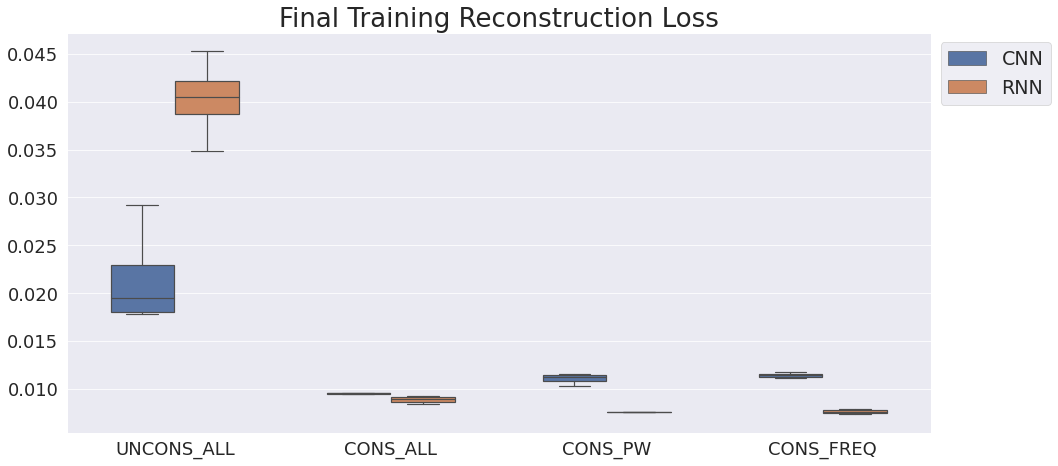

   Experiment       CNN       RNN
0  UNCONS_ALL  0.019153  0.039212
1  UNCONS_ALL  0.018141  0.033251
2  UNCONS_ALL  0.029229  0.041590
3  UNCONS_ALL  0.021509  0.041073
0    CONS_ALL  0.009684  0.010948
1    CONS_ALL  0.009379  0.011257
2    CONS_ALL  0.009454  0.011268
0     CONS_PW  0.010837  0.009007
1     CONS_PW  0.013457       NaN
2     CONS_PW  0.011587       NaN
0   CONS_FREQ  0.011246  0.008811
1   CONS_FREQ  0.012745  0.010165
2   CONS_FREQ  0.011200       NaN


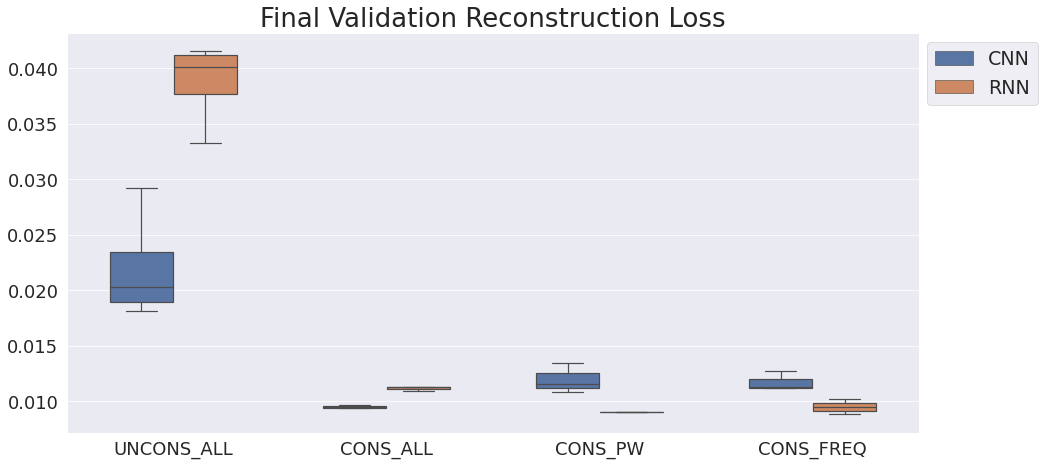

   Experiment       CNN       RNN
0  UNCONS_ALL  0.085582  0.109377
1  UNCONS_ALL  0.085527  0.082155
2  UNCONS_ALL  0.077000  0.111996
3  UNCONS_ALL  0.136412  0.113105
0    CONS_ALL  0.141954  0.141610
1    CONS_ALL  0.135973  0.140000
2    CONS_ALL  0.132197  0.145265
0     CONS_PW  0.214568  0.216639
1     CONS_PW  0.218969       NaN
2     CONS_PW  0.215239       NaN
0   CONS_FREQ  0.223471  0.205298
1   CONS_FREQ  0.208470  0.221066
2   CONS_FREQ  0.216397       NaN


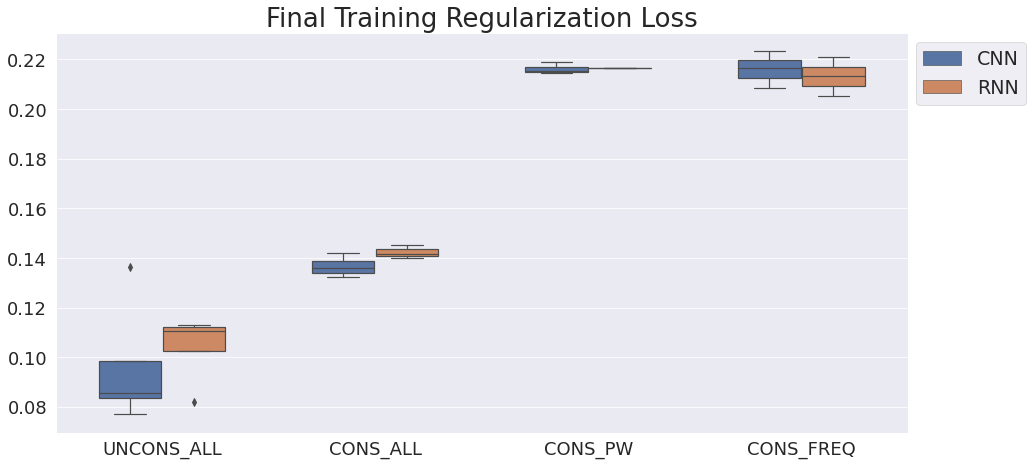

   Experiment       CNN       RNN
0  UNCONS_ALL  0.087582  0.110624
1  UNCONS_ALL  0.085933  0.077805
2  UNCONS_ALL  0.079035  0.110538
3  UNCONS_ALL  0.139990  0.116355
0    CONS_ALL  0.132479  0.133741
1    CONS_ALL  0.132461  0.134961
2    CONS_ALL  0.132467  0.133426
0     CONS_PW  0.201826  0.201832
1     CONS_PW  0.202823       NaN
2     CONS_PW  0.202264       NaN
0   CONS_FREQ  0.201619  0.201772
1   CONS_FREQ  0.201614  0.201619
2   CONS_FREQ  0.201568       NaN


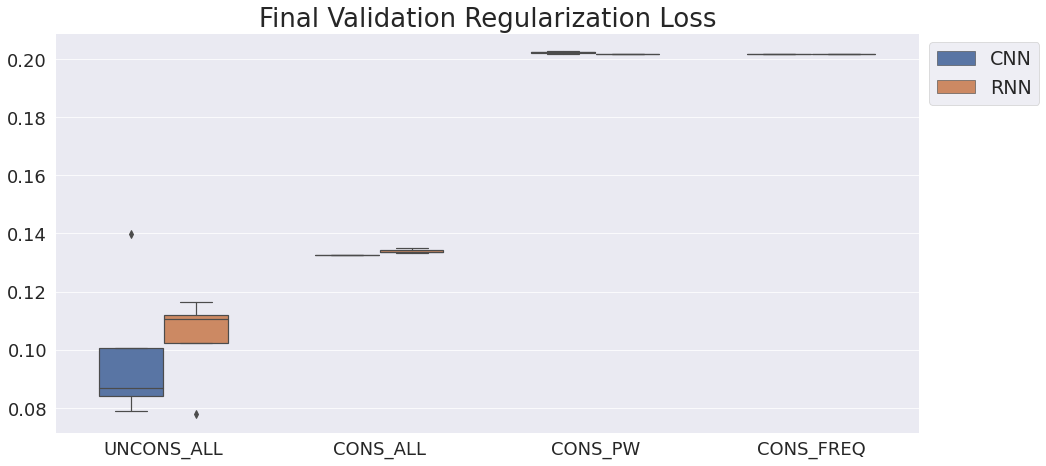

In [18]:
experiments_in_boxplots(loss_to_plot='train_total')
experiments_in_boxplots(loss_to_plot='val_total')
experiments_in_boxplots(loss_to_plot='train_recon')
experiments_in_boxplots(loss_to_plot='val_recon')
experiments_in_boxplots(loss_to_plot='train_reg')
experiments_in_boxplots(loss_to_plot='val_reg')

In [ ]:
  cnn_uncons=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'CNN': data_cnn_uncons[i][0]}) #ADD MISSING SEED #MISSING 1
    cnn_cons_all=pd.DataFrame({'Experiment':['CONS_ALL 0', 'CONS_ALL 1', 'CONS_ALL 2'], 'CNN': data_cnn_cons_onfr2[i][0]}) #ADD MISSING SEEDS! #MISSING 2
    # cnn_cons_amp=pd.DataFram  e({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3', 'CONS_AMP 4'], 'CNN': data_cnn_cons1_amp[i][0]}) #MISSING 5!!
    cnn_cons_pw=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'CNN': data_cnn_cons1_pw[i][0]}) #MISSING 2
    cnn_cons_freq=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'CNN': data_cnn_cons1_freq[i][0]}) #MISSING 2


    # print(normal_avg)
    df_cnn=pd.concat([cnn_uncons, cnn_cons_all, cnn_cons_pw, cnn_cons_freq])#, canny_avg, e2e_avg, blind_avg])
    # df_cnn=pd.concat([cnn_uncons, cnn_cons_all, cnn_cons_amp, cnn_cons_pw, cnn_cons_freq])#, canny_avg, e2e_avg, blind_avg])


    rnn_uncons=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'RNN': data_rnn_uncons[i][0]})  #ADD MISSING SEED #MISSING 1
    rnn_cons_all=pd.DataFrame({'Experiment':['CONS_ALL 0', 'CONS_ALL 1', 'CONS_ALL 2', 'CONS_ALL 3', 'CONS_ALL 4'], 'RNN': data_rnn_cons_onfr2[i][0]}) #ALL HERE
    # rnn_cons_amp=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'RNN': data_rnn_cons1_amp[1][0]}) #MISSING 3
    rnn_cons_pw=pd.DataFrame({'Experiment':['CONS_PW 0'], 'RNN': data_rnn_cons1_pw[i][0]}) #MISSING 4
    rnn_cons_freq=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'RNN': data_rnn_cons1_freq[i][0]}) #MISSING 3

    Experiment  Total Training Loss  Total Validation Loss  \
0   UNCONS_ALL             0.051711               0.053367   
0   UNCONS_ALL             0.051711               0.053367   
0   UNCONS_ALL             0.051711               0.053367   
0   UNCONS_ALL             0.051711               0.053367   
0   UNCONS_ALL             0.051711               0.053367   
..         ...                  ...                    ...   
1      CONS_PW             0.115280               0.108140   
2      CONS_PW             0.113252               0.106925   
0    CONS_FREQ             0.117289               0.106432   
1    CONS_FREQ             0.109935               0.107179   
2    CONS_FREQ             0.114081               0.106384   

    Reconstruction Training Loss  Reconstruction Validation Loss  \
0                       0.017841                        0.019153   
0                       0.017841                        0.019153   
0                       0.017841                   

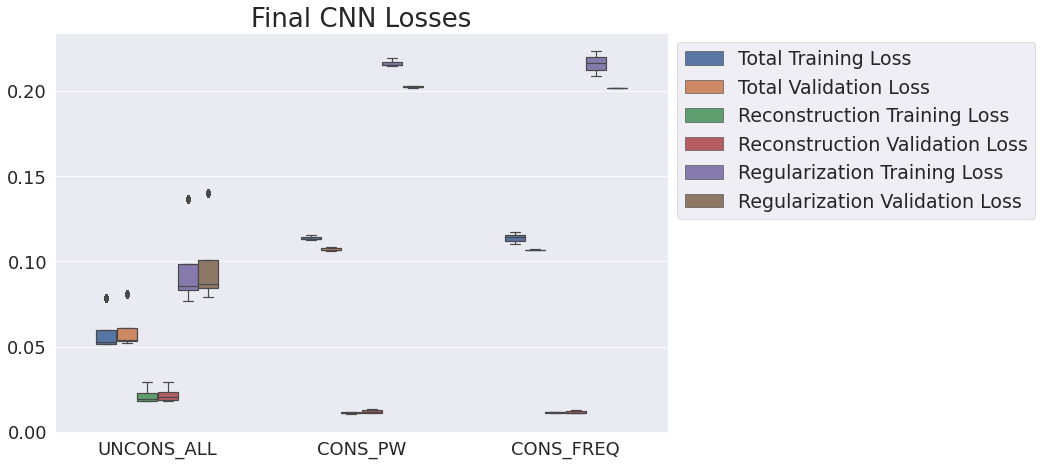

In [36]:

df_cnn=[]
cnn_uncons_train_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Training Loss': data_cnn_uncons[0][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_train_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Training Loss': data_cnn_uncons[0][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_train_total=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Total Training Loss': data_cnn_cons1_amp[0][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_train_total=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Total Training Loss': data_cnn_cons1_pw[0][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_train_total=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Total Training Loss': data_cnn_cons1_freq[0][0]}) #ADD MISSING SEED #MISSING 1

df_total_train=pd.concat([cnn_uncons_train_total, cnn_cons_all_train_total, cnn_cons_pw_train_total, cnn_cons_freq_train_total])
# df_total_train=pd.concat([cnn_uncons_train_total, cnn_cons_all_train_total, cnn_cons_amp_train_total, cnn_cons_pw_train_total, cnn_cons_freq_train_total])

cnn_uncons_val_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Validation Loss': data_cnn_uncons[1][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_val_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Validation Loss': data_cnn_uncons[1][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_val_total=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Total Validation Loss': data_cnn_cons1_amp[1][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_val_total=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Total Validation Loss': data_cnn_cons1_pw[1][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_val_total=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Total Validation Loss': data_cnn_cons1_freq[1][0]}) #ADD MISSING SEED #MISSING 1

df_total_val=pd.concat([cnn_uncons_val_total, cnn_cons_all_val_total, cnn_cons_pw_val_total, cnn_cons_freq_val_total])
# df_total_val=pd.concat([cnn_uncons_val_total, cnn_cons_all_val_total, cnn_cons_amp_val_total, cnn_cons_pw_val_total, cnn_cons_freq_val_total])

cnn_uncons_train_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Training Loss': data_cnn_uncons[2][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_train_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Training Loss': data_cnn_uncons[2][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_train_recon=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Reconstruction Training Loss': data_cnn_cons1_amp[2][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_train_recon=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Reconstruction Training Loss': data_cnn_cons1_pw[2][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_train_recon=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Reconstruction Training Loss': data_cnn_cons1_freq[2][0]}) #ADD MISSING SEED #MISSING 1

df_recon_train=pd.concat([cnn_uncons_train_recon, cnn_cons_all_train_recon, cnn_cons_pw_train_recon, cnn_cons_freq_train_recon])
# df_recon_train=pd.concat([cnn_uncons_train_recon, cnn_cons_all_train_recon, cnn_cons_amp_train_recon, cnn_cons_pw_train_recon, cnn_cons_freq_train_recon])

cnn_uncons_val_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Validation Loss': data_cnn_uncons[3][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_val_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Validation Loss': data_cnn_uncons[3][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_val_recon=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Reconstruction Validation Loss': data_cnn_cons1_amp[3][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_val_recon=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Reconstruction Validation Loss': data_cnn_cons1_pw[3][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_val_recon=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Reconstruction Validation Loss': data_cnn_cons1_freq[3][0]}) #ADD MISSING SEED #MISSING 1

df_recon_val=pd.concat([cnn_uncons_val_recon, cnn_cons_all_val_recon, cnn_cons_pw_val_recon, cnn_cons_freq_val_recon])
# df_recon_val=pd.concat([cnn_uncons_val_recon, cnn_cons_all_val_recon, cnn_cons_amp_val_recon, cnn_cons_pw_val_recon, cnn_cons_freq_val_recon])

cnn_uncons_train_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Training Loss': data_cnn_uncons[4][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_train_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Training Loss': data_cnn_uncons[4][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_train_reg=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Regularization Training Loss': data_cnn_cons1_amp[4][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_train_reg=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Regularization Training Loss': data_cnn_cons1_pw[4][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_train_reg=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Regularization Training Loss': data_cnn_cons1_freq[4][0]}) #ADD MISSING SEED #MISSING 1

df_reg_train=pd.concat([cnn_uncons_train_reg, cnn_cons_all_train_reg, cnn_cons_pw_train_reg, cnn_cons_freq_train_reg])
# df_reg_train=pd.concat([cnn_uncons_train_reg, cnn_cons_all_train_reg, cnn_cons_amp_train_reg, cnn_cons_pw_train_reg, cnn_cons_freq_train_reg])

cnn_uncons_val_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Validation Loss': data_cnn_uncons[5][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_all_val_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Validation Loss': data_cnn_uncons[5][0]}) #ADD MISSING SEED #MISSING 1
# cnn_cons_amp_val_reg=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1', 'CONS_AMP 2', 'CONS_AMP 3'], 'Regularization Validation Loss': data_cnn_cons1_amp[5][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_pw_val_reg=pd.DataFrame({'Experiment':['CONS_PW 0', 'CONS_PW 1', 'CONS_PW 2'], 'Regularization Validation Loss': data_cnn_cons1_pw[5][0]}) #ADD MISSING SEED #MISSING 1
cnn_cons_freq_val_reg=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1', 'CONS_FREQ 2'], 'Regularization Validation Loss': data_cnn_cons1_freq[5][0]}) #ADD MISSING SEED #MISSING 1

df_reg_val=pd.concat([cnn_uncons_val_reg, cnn_cons_all_val_reg, cnn_cons_pw_val_reg, cnn_cons_freq_val_reg])
# df_reg_val=pd.concat([cnn_uncons_val_reg, cnn_cons_all_val_reg, cnn_cons_amp_val_reg, cnn_cons_pw_val_reg, cnn_cons_freq_val_reg])


df_cnn=df_total_train.join(df_total_val.set_index('Experiment'), on='Experiment').join(df_recon_train.set_index('Experiment'), on='Experiment').join(df_recon_val.set_index('Experiment'), on='Experiment').join(df_reg_train.set_index('Experiment'), on='Experiment').join(df_reg_val.set_index('Experiment'), on='Experiment')
df_cnn['Experiment']=df_cnn['Experiment'].apply(lambda x: x.split(' ')[0])

print(df_cnn)

fig = plt.figure(figsize =(15, 7))
dd=pd.melt(df_cnn,id_vars=['Experiment'],value_vars=['Total Training Loss','Total Validation Loss', 'Reconstruction Training Loss','Reconstruction Validation Loss', 'Regularization Training Loss','Regularization Validation Loss'],var_name='Loss')
sns.set_theme()#style="whitegrid")
sns.set_context("paper", font_scale=2.5) 
sns.boxplot(x='Experiment', y='value',data=dd,hue='Loss', width=0.6)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title(f'Final CNN Losses', fontsize=26)
plt.legend()

plt.legend(fontsize=19, bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.tight_layout()

plt.show()

    Experiment  Total Training Loss  Total Validation Loss  \
0   UNCONS_ALL             0.075216               0.074918   
0   UNCONS_ALL             0.075216               0.074918   
0   UNCONS_ALL             0.075216               0.074918   
0   UNCONS_ALL             0.075216               0.074918   
0   UNCONS_ALL             0.075216               0.074918   
..         ...                  ...                    ...   
3   UNCONS_ALL             0.076539               0.078714   
3   UNCONS_ALL             0.076539               0.078714   
0      CONS_PW             0.112113               0.105420   
0    CONS_FREQ             0.106315               0.105291   
1    CONS_FREQ             0.114479               0.105892   

    Reconstruction Training Loss  Reconstruction Validation Loss  \
0                       0.041055                        0.039212   
0                       0.041055                        0.039212   
0                       0.041055                   

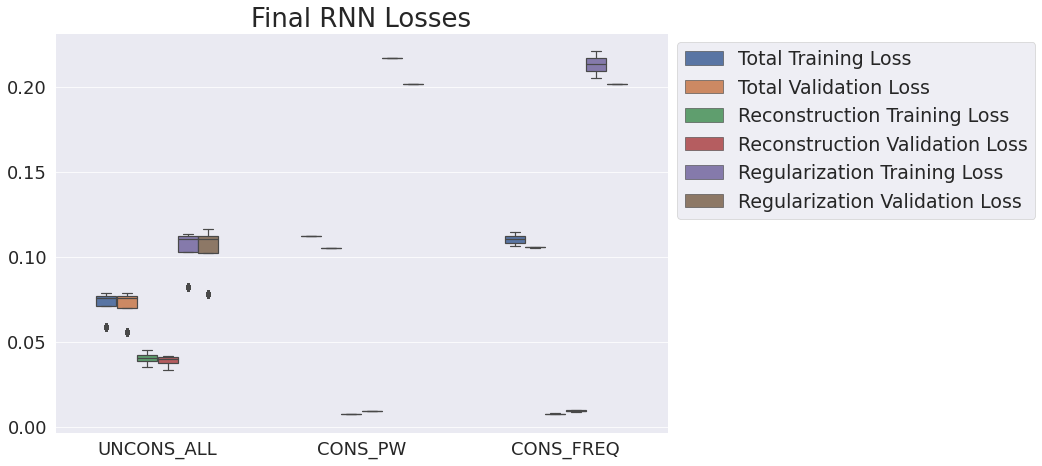

In [51]:

df_rnn=[]
rnn_uncons_train_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Training Loss': data_rnn_uncons[0][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_train_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Training Loss': data_rnn_uncons[0][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_train_total=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Total Training Loss': data_rnn_cons1_amp[0][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_train_total=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Total Training Loss': data_rnn_cons1_pw[0][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_train_total=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Total Training Loss': data_rnn_cons1_freq[0][0]}) #ADD MISSING SEED #MISSING 1

df_total_train=pd.concat([rnn_uncons_train_total, rnn_cons_all_train_total, rnn_cons_pw_train_total, rnn_cons_freq_train_total])

rnn_uncons_val_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Validation Loss': data_rnn_uncons[1][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_val_total=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Total Validation Loss': data_rnn_uncons[1][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_val_total=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Total Validation Loss': data_rnn_cons1_amp[1][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_val_total=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Total Validation Loss': data_rnn_cons1_pw[1][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_val_total=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Total Validation Loss': data_rnn_cons1_freq[1][0]}) #ADD MISSING SEED #MISSING 1

df_total_val=pd.concat([rnn_uncons_val_total, rnn_cons_all_val_total, rnn_cons_pw_val_total, rnn_cons_freq_val_total])

rnn_uncons_train_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Training Loss': data_rnn_uncons[2][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_train_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Training Loss': data_rnn_uncons[2][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_train_recon=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Reconstruction Training Loss': data_rnn_cons1_amp[2][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_train_recon=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Reconstruction Training Loss': data_rnn_cons1_pw[2][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_train_recon=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Reconstruction Training Loss': data_rnn_cons1_freq[2][0]}) #ADD MISSING SEED #MISSING 1

df_recon_train=pd.concat([rnn_uncons_train_recon, rnn_cons_all_train_recon, rnn_cons_pw_train_recon, rnn_cons_freq_train_recon])

rnn_uncons_val_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Validation Loss': data_rnn_uncons[3][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_val_recon=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Reconstruction Validation Loss': data_rnn_uncons[3][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_val_recon=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Reconstruction Validation Loss': data_rnn_cons1_amp[3][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_val_recon=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Reconstruction Validation Loss': data_rnn_cons1_pw[3][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_val_recon=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Reconstruction Validation Loss': data_rnn_cons1_freq[3][0]}) #ADD MISSING SEED #MISSING 1

df_recon_val=pd.concat([rnn_uncons_val_recon, rnn_cons_all_val_recon, rnn_cons_pw_val_recon, rnn_cons_freq_val_recon])

rnn_uncons_train_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Training Loss': data_rnn_uncons[4][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_train_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Training Loss': data_rnn_uncons[4][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_train_reg=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Regularization Training Loss': data_rnn_cons1_amp[4][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_train_reg=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Regularization Training Loss': data_rnn_cons1_pw[4][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_train_reg=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Regularization Training Loss': data_rnn_cons1_freq[4][0]}) #ADD MISSING SEED #MISSING 1

df_reg_train=pd.concat([rnn_uncons_train_reg, rnn_cons_all_train_reg, rnn_cons_pw_train_reg, rnn_cons_freq_train_reg])

rnn_uncons_val_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Validation Loss': data_rnn_uncons[5][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_all_val_reg=pd.DataFrame({'Experiment':['UNCONS_ALL 0', 'UNCONS_ALL 1', 'UNCONS_ALL 2', 'UNCONS_ALL 3'], 'Regularization Validation Loss': data_rnn_uncons[5][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_amp_val_reg=pd.DataFrame({'Experiment':['CONS_AMP 0', 'CONS_AMP 1'], 'Regularization Validation Loss': data_rnn_cons1_amp[5][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_pw_val_reg=pd.DataFrame({'Experiment':['CONS_PW 0'], 'Regularization Validation Loss': data_rnn_cons1_pw[5][0]}) #ADD MISSING SEED #MISSING 1
rnn_cons_freq_val_reg=pd.DataFrame({'Experiment':['CONS_FREQ 0', 'CONS_FREQ 1'], 'Regularization Validation Loss': data_rnn_cons1_freq[5][0]}) #ADD MISSING SEED #MISSING 1

df_reg_val=pd.concat([rnn_uncons_val_reg, rnn_cons_all_val_reg, rnn_cons_pw_val_reg, rnn_cons_freq_val_reg])


df_rnn=df_total_train.join(df_total_val.set_index('Experiment'), on='Experiment').join(df_recon_train.set_index('Experiment'), on='Experiment').join(df_recon_val.set_index('Experiment'), on='Experiment').join(df_reg_train.set_index('Experiment'), on='Experiment').join(df_reg_val.set_index('Experiment'), on='Experiment')
df_rnn['Experiment']=df_rnn['Experiment'].apply(lambda x: x.split(' ')[0])

print(df_rnn)

fig = plt.figure(figsize =(15, 7))
dd=pd.melt(df_rnn,id_vars=['Experiment'],value_vars=['Total Training Loss','Total Validation Loss', 'Reconstruction Training Loss','Reconstruction Validation Loss', 'Regularization Training Loss','Regularization Validation Loss'],var_name='Loss')
sns.set_theme()#style="whitegrid")
sns.set_context("paper", font_scale=2.5) 
sns.boxplot(x='Experiment', y='value',data=dd,hue='Loss', width=0.6)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title(f'Final RNN Losses', fontsize=26)
plt.legend()

plt.legend(fontsize=19, bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.tight_layout()

plt.show()

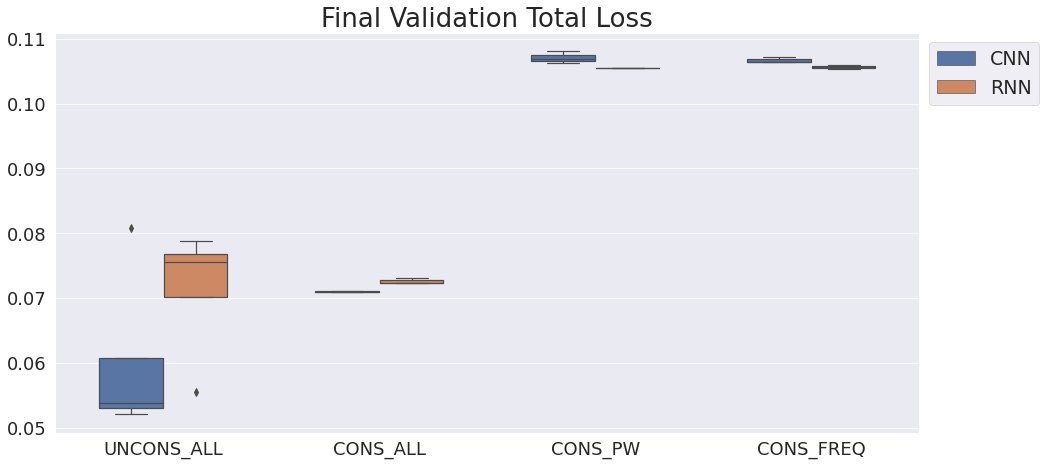

In [73]:
fig = plt.figure(figsize =(15, 7))
dd=pd.melt(df,id_vars=['Experiment'],value_vars=['CNN','RNN'],var_name='Loss')
sns.set_theme()#style="whitegrid")
sns.set_context("paper", font_scale=2.5) 
sns.boxplot(x='Experiment', y='value',data=dd,hue='Loss', width=0.6)
plt.ylabel('')
plt.xlabel('')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Final Validation Total Loss', fontsize=26)
plt.legend()

plt.legend(fontsize=19, bbox_to_anchor=(1.15, 1.0),loc='upper right')
plt.tight_layout()

plt.show()

In [202]:
#within exp loss values
fig = plt.figure(figsize =(10, 7))

df=[]
cnn_uncons_tr_total=pd.DataFrame({'Experiment':['CNN_UNCONS TR 0', 'CNN_UNCONS TR 1', 'CNN_UNCONS TR 3', 'CNN_UNCONS TR 4'], 'Tr. Total Loss':data_cnn_uncons[0][0]})
cnn_uncons_tr_recon=pd.DataFrame({'Experiment':['CNN_UNCONS TR 0', 'CNN_UNCONS TR 1', 'CNN_UNCONS TR 3', 'CNN_UNCONS TR 4'], 'Tr. Recon. Loss':data_cnn_uncons[2][0]})
# cnn_uncons_tr_reg=pd.DataFrame({'Experiment':['CNN_UNCONS 0', 'CNN_UNCONS 1', 'CNN_UNCONS 3', 'CNN_UNCONS 4'], 'Tr. Reg. Loss':data_cnn_uncons[4][0]})
# canny_avg=pd.DataFrame({'Experiment':['Canny 0', 'Canny 1', 'Canny 2', 'Canny 3', 'Canny 4'], 'Avg.':canny_reward_avg.fillna(method='ffill').iloc[-1]})
# e2e_avg=pd.DataFrame({'Experiment':['E2E 0', 'E2E 1', 'E2E 2', 'E2E 3', 'E2E 4'], 'Avg.':e2e_reward_avg.fillna(method='ffill').iloc[-1]})
# blind_avg=pd.DataFrame({'Experiment':['Blind 0', 'Blind 1', 'Blind 2', 'Blind 3', 'Blind 4'], 'Avg.':blind_reward_avg.fillna(method='ffill').iloc[-1]})

# print(normal_avg)
df_tr=pd.concat([cnn_uncons_tr_total,cnn_uncons_tr_recon])#,cnn_uncons_tr_reg])#, canny_avg, e2e_avg, blind_avg])


cnn_uncons_val_total=pd.DataFrame({'Experiment':['CNN_UNCONS VAL 0', 'CNN_UNCONS VAL 1', 'CNN_UNCONS VAL 3', 'CNN_UNCONS VAL 4'], 'Val. Total Loss':data_cnn_uncons[1][0]})
cnn_uncons_val_recon=pd.DataFrame({'Experiment':['CNN_UNCONS VAL 0', 'CNN_UNCONS VAL 1', 'CNN_UNCONS VAL 3', 'CNN_UNCONS VAL 4'], 'Val. Recon. Loss':data_cnn_uncons[3][0]})
# cnn_uncons_val_reg=pd.DataFrame({'Experiment':['CNN_UNCONS 0', 'CNN_UNCONS 1', 'CNN_UNCONS 3', 'CNN_UNCONS 4'], 'Val. Reg Loss':data_cnn_uncons[5][0]})

# canny_max=pd.DataFrame({'Experiment':['Canny 0', 'Canny 1', 'Canny 2', 'Canny 3', 'Canny 4'], 'Max.':canny_reward_max.fillna(method='ffill').iloc[-1]})
# e2e_max=pd.DataFrame({'Experiment':['E2E 0', 'E2E 1', 'E2E 2', 'E2E 3', 'E2E 4'], 'Max.':e2e_reward_max.fillna(method='ffill').iloc[-1]})
# blind_max=pd.DataFrame({'Experiment':['Blind 0', 'Blind 1', 'Blind 2', 'Blind 3', 'Blind 4'], 'Max.':blind_reward_max.fillna(method='ffill').iloc[-1]})

df_val=pd.concat([cnn_uncons_val_total,cnn_uncons_val_recon])#,cnn_uncons_val_reg])#, canny_max, e2e_max, blind_max])


df=df_tr.join(df_val.set_index('Experiment'), on='Experiment')
df['Experiment']=df['Experiment'].apply(lambda x: x.split(' ')[0])

print(df)

   Experiment  Tr. Total Loss  Tr. Recon. Loss  Val. Total Loss  \
0  CNN_UNCONS        0.051711              NaN              NaN   
1  CNN_UNCONS        0.051812              NaN              NaN   
2  CNN_UNCONS        0.053101              NaN              NaN   
3  CNN_UNCONS        0.078638              NaN              NaN   
0  CNN_UNCONS             NaN         0.017841              NaN   
1  CNN_UNCONS             NaN         0.018097              NaN   
2  CNN_UNCONS             NaN         0.029202              NaN   
3  CNN_UNCONS             NaN         0.020864              NaN   

   Val. Recon. Loss  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
0               NaN  
1               NaN  
2               NaN  
3               NaN  


<Figure size 720x504 with 0 Axes>

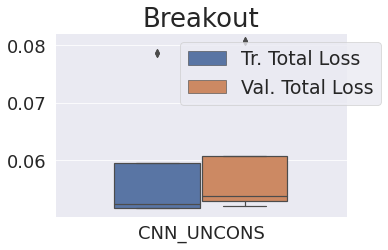

In [201]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# dd=pd.melt(df,id_vars=['Experiment'],value_vars=['Tr. Total Loss','Val. Total Loss'],var_name='Loss')
# sns.set_theme()#style="whitegrid")
# sns.set_context("paper", font_scale=2.5) 
# sns.boxplot(x='Experiment', y='value',data=dd,hue='Loss', width=0.6)
# plt.ylabel('')
# plt.xlabel('')
# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)
# plt.title('Breakout', fontsize=26)
# plt.legend()

# plt.legend(fontsize=19, bbox_to_anchor=(1.15, 1.0),loc='upper right')
# plt.tight_layout()

# plt.show()

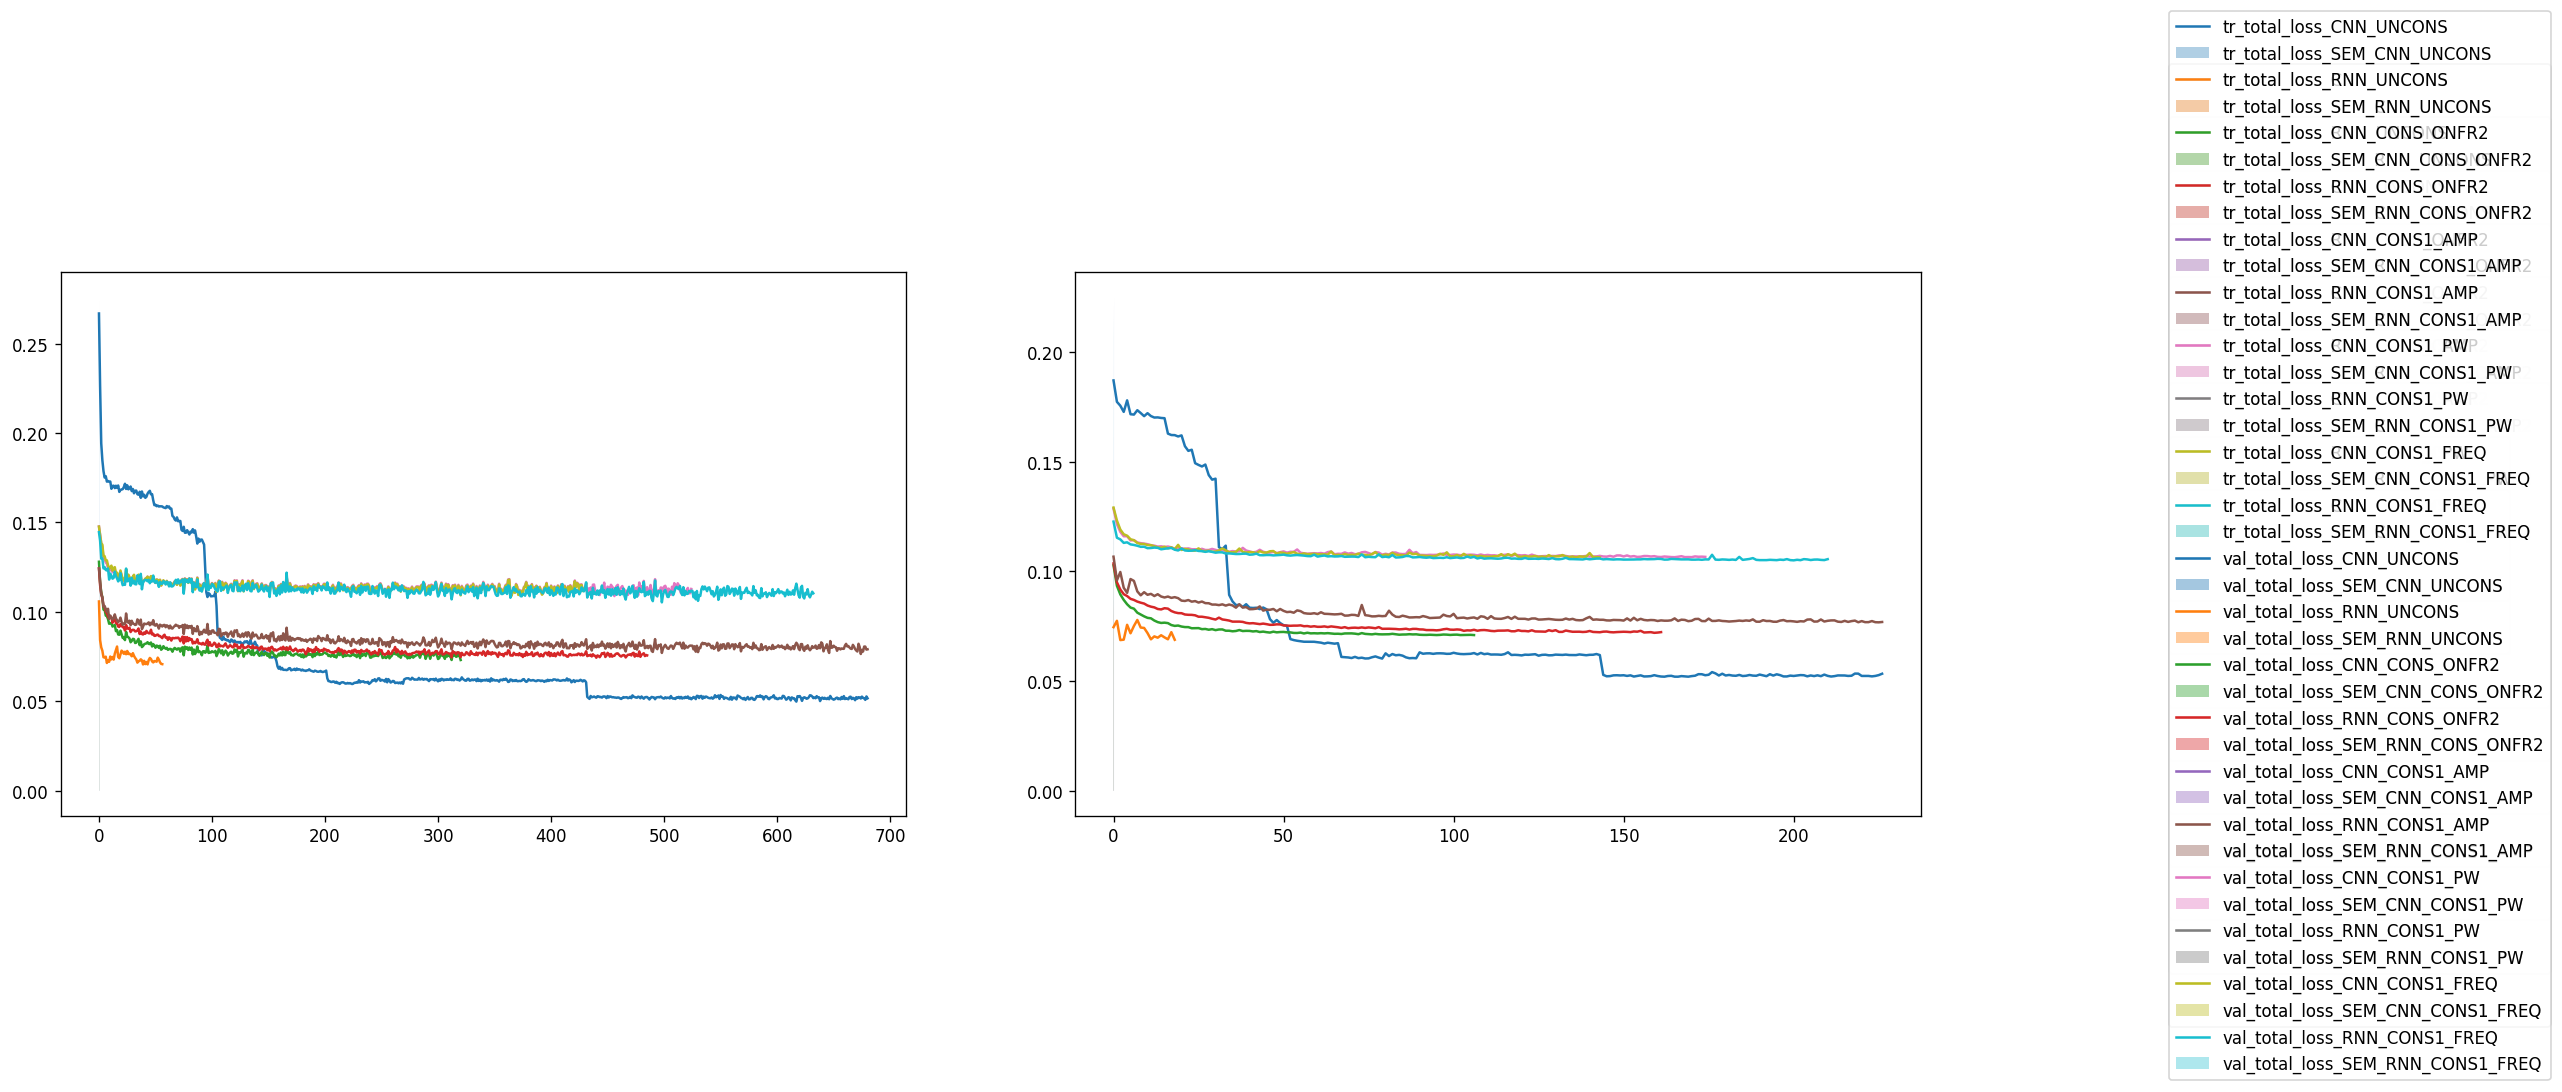

In [106]:
plot_across_experiments_total(exp_dir, df_train_all, df_val_all, total=True, recon=False, regul=False)

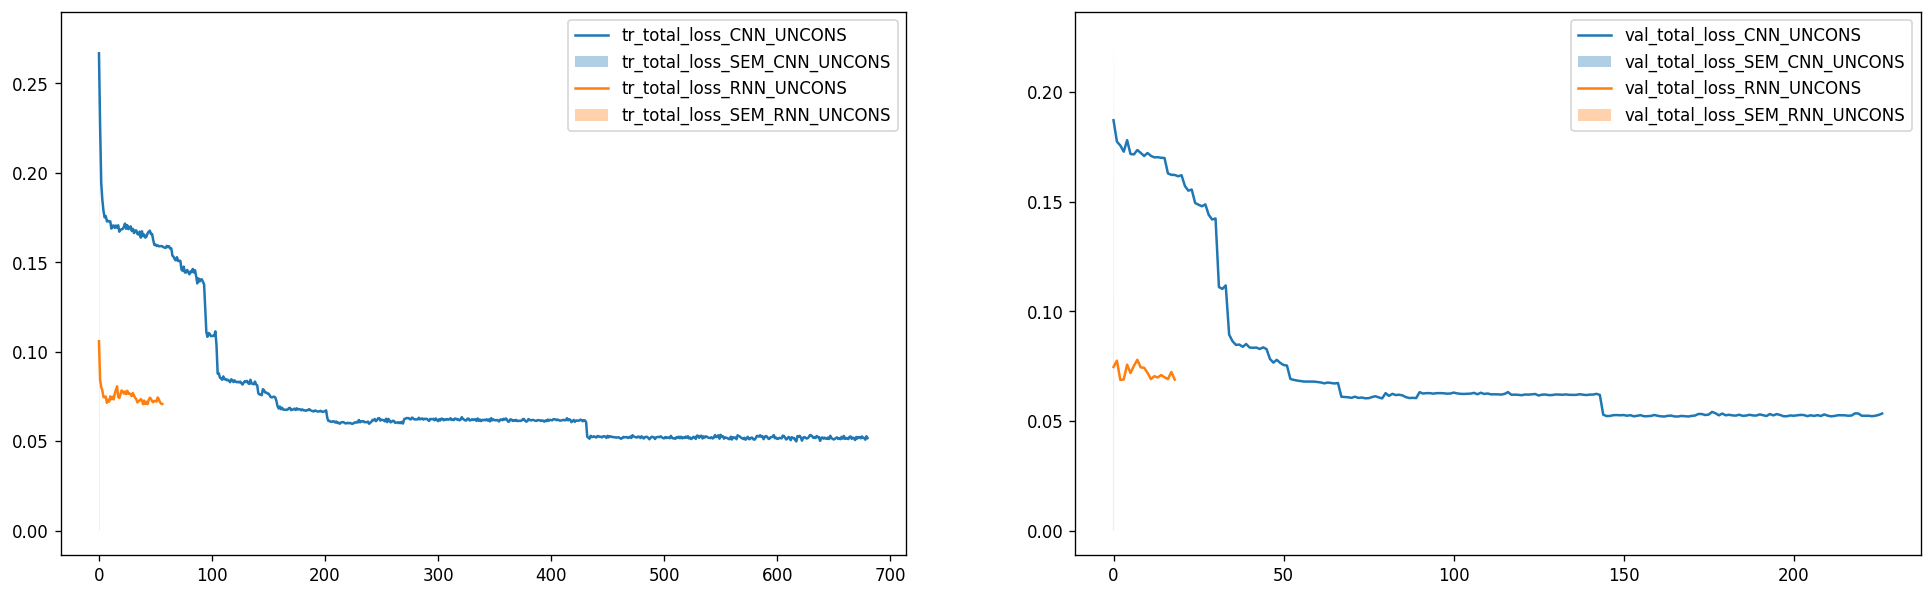

In [46]:
plot_across_experiments_total(exp_dir_uncons, df_train_all, df_val_all, total=True, recon=False, regul=False)

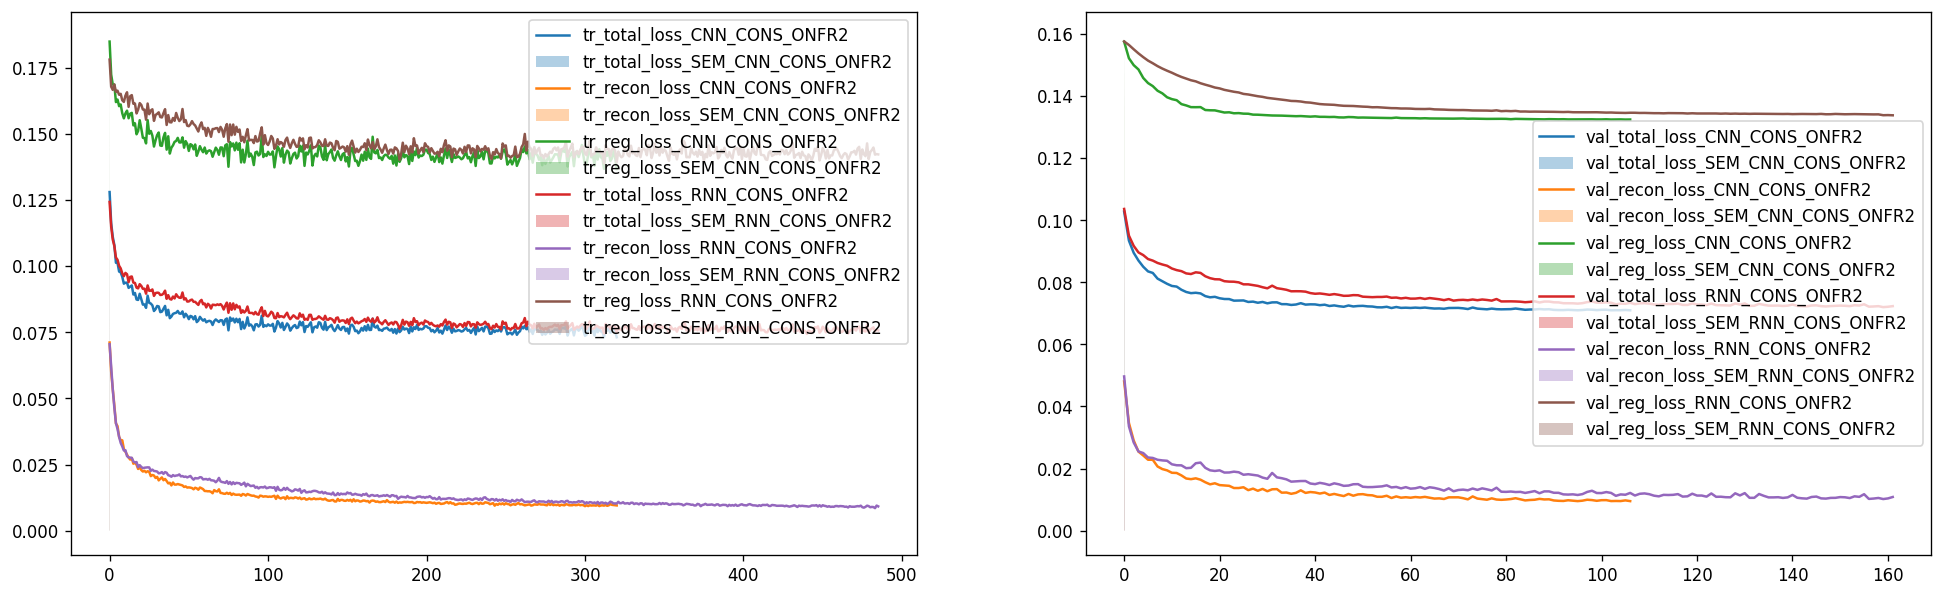

In [51]:
plot_across_experiments_total(exp_dir_cons_onfr2, df_train_all, df_val_all, total=True, recon=True, regul=True)

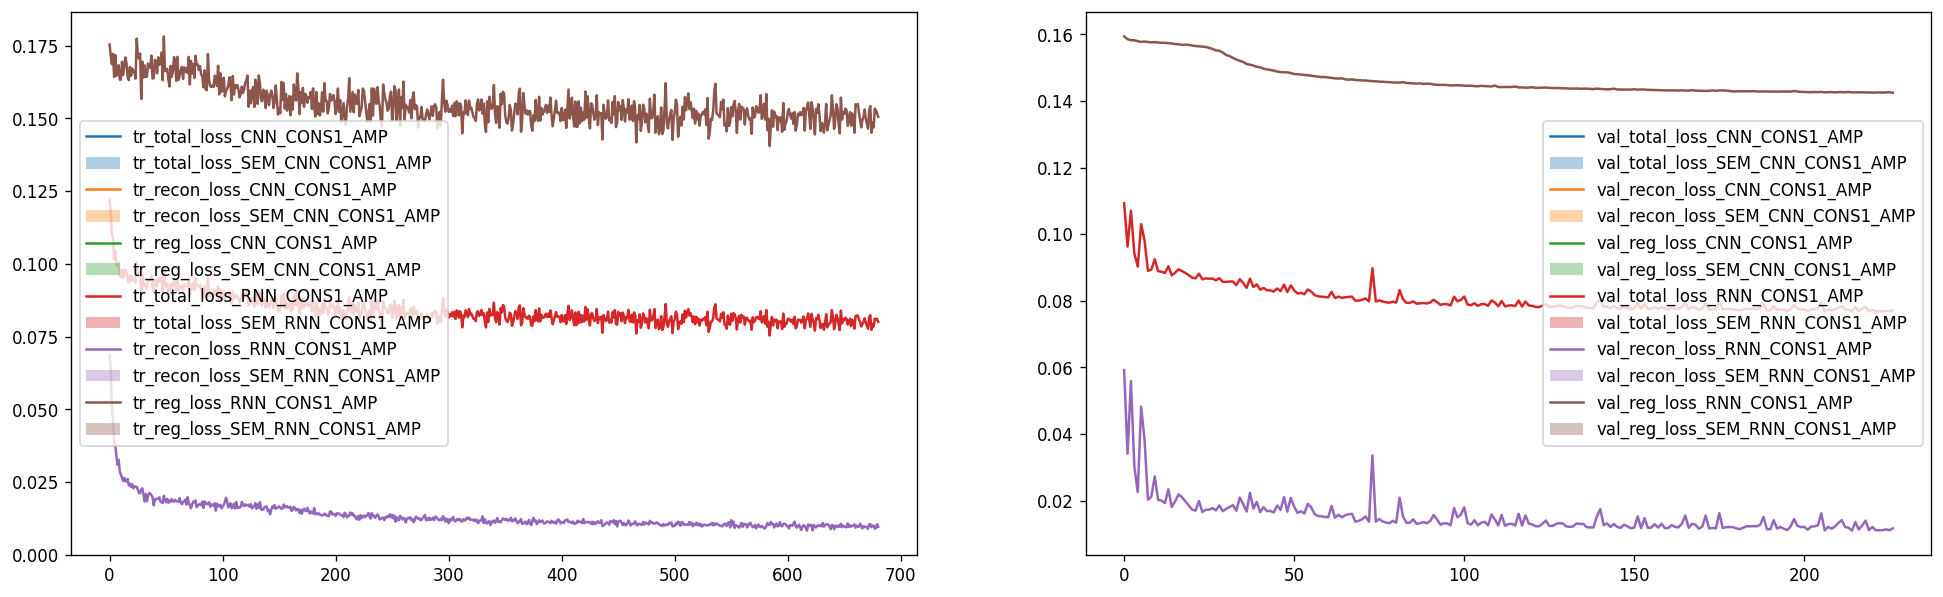

In [54]:
plot_across_experiments_total(exp_dir_1cons_amp, df_train_all, df_val_all, total=True, recon=True, regul=True)

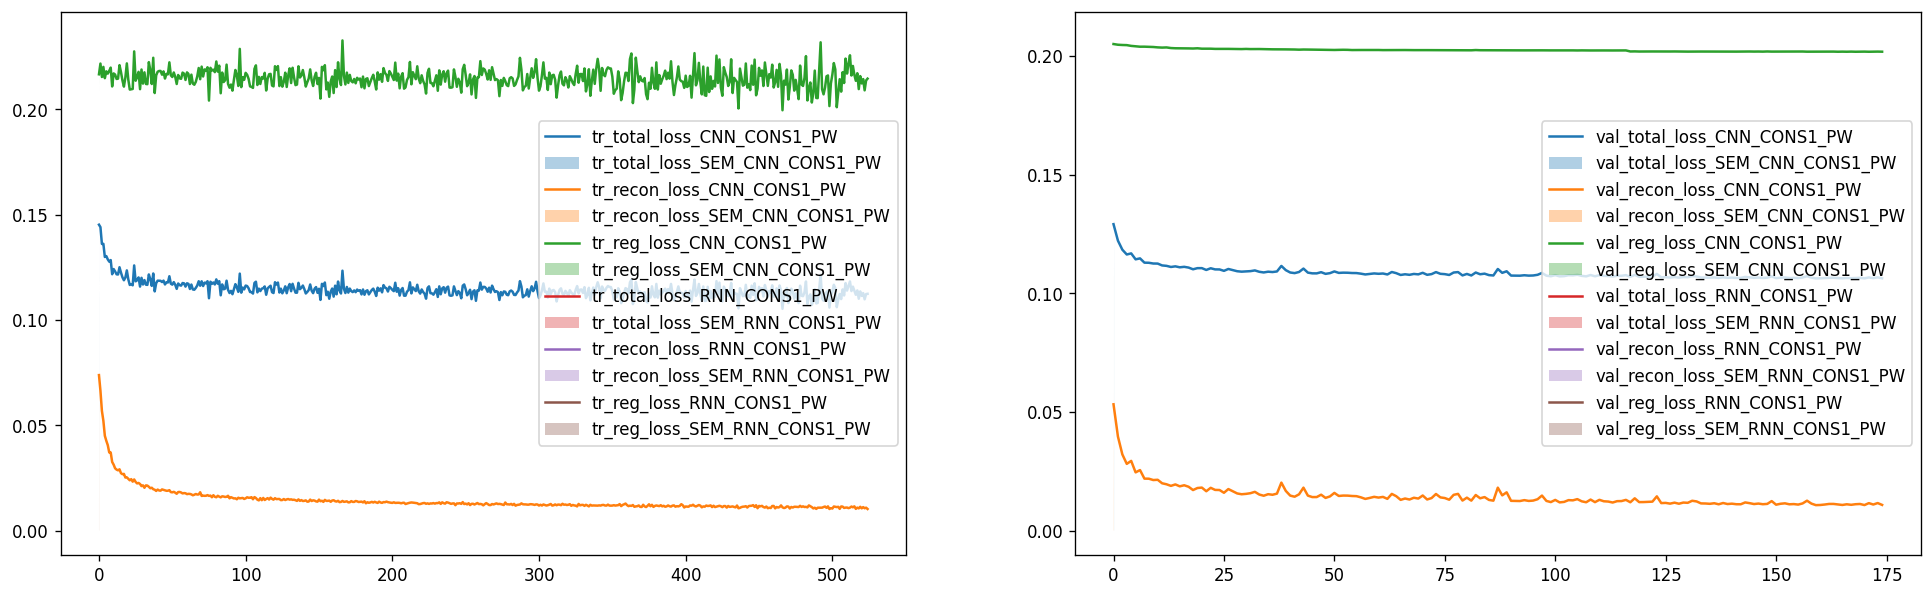

In [55]:
plot_across_experiments_total(exp_dir_1cons_pw, df_train_all, df_val_all, total=True, recon=True, regul=True)

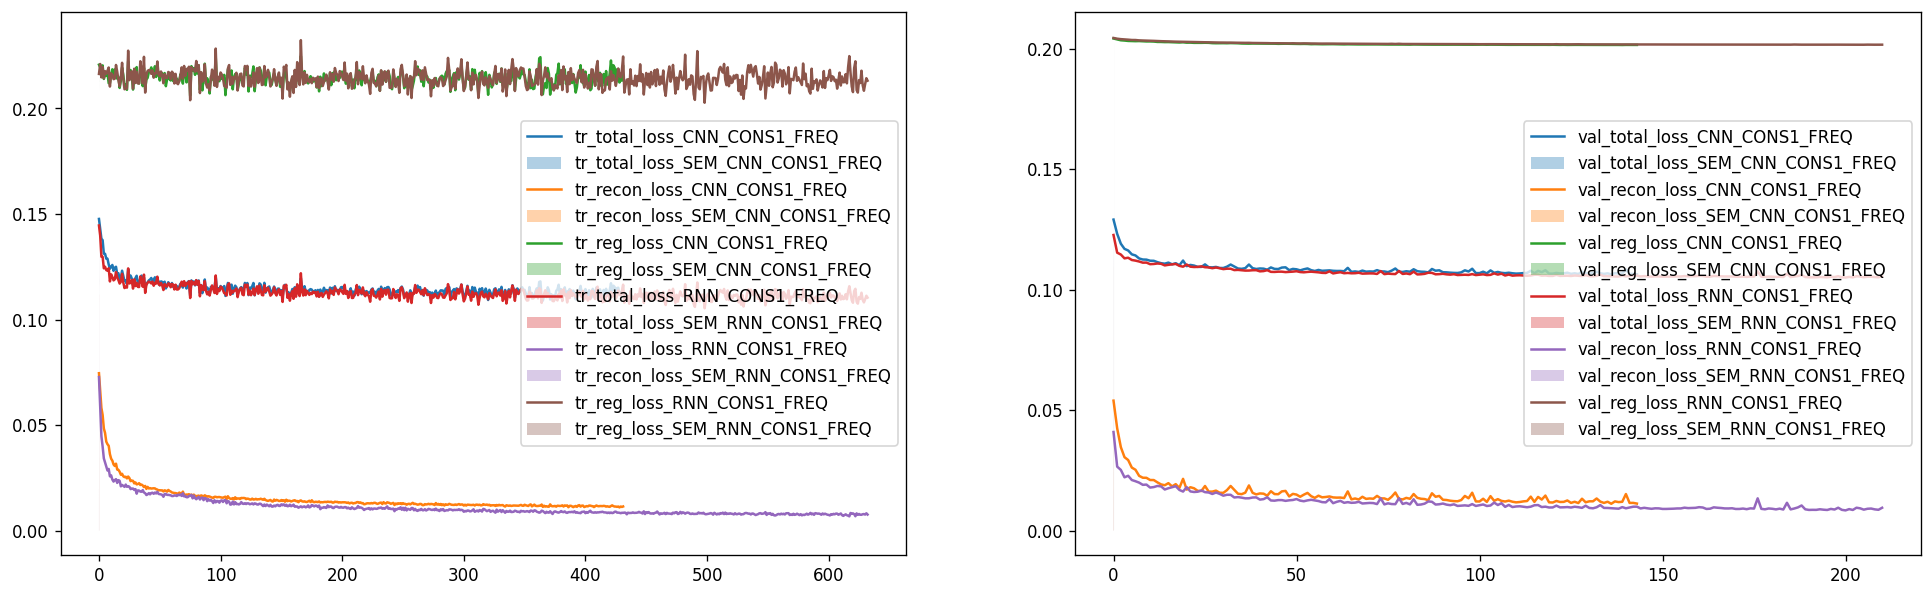

In [56]:
plot_across_experiments_total(exp_dir_1cons_freq, df_train_all, df_val_all, total=True, recon=True, regul=True)

In [ ]:
plot_across_experiments_total(exp_dir_1cons_freq, df_train_all, df_val_all, total=True, recon=True, regul=True)

In [56]:
transform_list = ["input", "phosphenes", "reconstruction", "stimulation_amplitude",  "stimulation_pulse_width",  "stimulation_frequency",  "total_charge"]

In [58]:
def load_transform(directory, exp_name, exp_dir,seed, stimulation_parameter):
    transform_dict = {}
    # for item in transform_list:
    file=f'{directory}{exp_dir[exp_name][seed]}/output_history/{stimulation_parameter}.pickle'
    f = open(file, 'rb')
    # transform_dict[item]=pickle5.load(f)
    transform_data=pickle5.load(f)
    # print(transform_dict[item])
    return transform_data

In [94]:
amplitude_cnn_uncons = load_transform(directory, "CNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
amplitude_rnn_uncons = load_transform(directory, "RNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
amplitude_cnn_cons3 = load_transform(directory, "CNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
amplitude_rnn_cons3 = load_transform(directory, "RNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
# amplitude_cnn_cons_amp = load_transform(directory, "CNN_CONS1_AMP", exp_dir, seed=0, stimulation_parameter="stimulation_amplitude")
amplitude_rnn_cons_amp = load_transform(directory, "RNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
# amplitude_cnn_cons_pw = load_transform(directory, "CNN_CONS1_PW", exp_dir, seed=1, stimulation_parameter="stimulation_amplitude")
# amplitude_rnn_cons_pw = load_transform(directory, "RNN_CONS1_PW", exp_dir, seed=2, stimulation_parameter="stimulation_amplitude")
# amplitude_cnn_cons_freq = load_transform(directory, "CNN_CONS1_FREQ", exp_dir, seed=2, stimulation_parameter="stimulation_amplitude")
# amplitude_rnn_cons_freq = load_transform(directory, "RNN_CONS1_FREQ", exp_dir, seed=2, stimulation_parameter="stimulation_amplitude")

In [101]:
pw_cnn_uncons = load_transform(directory, "CNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
pw_rnn_uncons = load_transform(directory, "RNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
pw_cnn_cons3 = load_transform(directory, "CNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
pw_rnn_cons3 = load_transform(directory, "RNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
# pw_cnn_cons_amp = load_transform(directory, "CNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
# pw_rnn_cons_amp = load_transform(directory, "RNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
pw_cnn_cons_pw = load_transform(directory, "CNN_CONS1_PW", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
pw_rnn_cons_pw = load_transform(directory, "RNN_CONS1_PW", exp_dir, seed=2, stimulation_parameter="stimulation_pulse_width")
# pw_cnn_cons_freq = load_transform(directory, "CNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")
# pw_rnn_cons_freq = load_transform(directory, "RNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="stimulation_pulse_width")

In [110]:
freq_cnn_uncons = load_transform(directory, "CNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
freq_rnn_uncons = load_transform(directory, "RNN_UNCONS", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
freq_cnn_cons3 = load_transform(directory, "CNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
freq_rnn_cons3 = load_transform(directory, "RNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
# freq_cnn_cons_amp = load_transform(directory, "CNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
# freq_rnn_cons_amp = load_transform(directory, "RNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
# freq_cnn_cons_pw = load_transform(directory, "CNN_CONS1_PW", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
# freq_rnn_cons_pw = load_transform(directory, "RNN_CONS1_PW", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
freq_cnn_cons_freq = load_transform(directory, "CNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")
freq_rnn_cons_freq = load_transform(directory, "RNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="stimulation_frequency")

In [130]:
current_cnn_uncons = load_transform(directory, "CNN_UNCONS", exp_dir, seed=1, stimulation_parameter="total_charge")
current_rnn_uncons = load_transform(directory, "RNN_UNCONS", exp_dir, seed=1, stimulation_parameter="total_charge")
current_cnn_cons3 = load_transform(directory, "CNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="total_charge")
current_rnn_cons3 = load_transform(directory, "RNN_CONS_ONFR2", exp_dir, seed=1, stimulation_parameter="total_charge")
# current_cnn_cons_amp = load_transform(directory, "CNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="total_charge")
current_rnn_cons_amp = load_transform(directory, "RNN_CONS1_AMP", exp_dir, seed=1, stimulation_parameter="total_charge")
current_cnn_cons_pw = load_transform(directory, "CNN_CONS1_PW", exp_dir, seed=1, stimulation_parameter="total_charge")
current_rnn_cons_pw = load_transform(directory, "RNN_CONS1_PW", exp_dir, seed=2, stimulation_parameter="total_charge")
current_cnn_cons_freq = load_transform(directory, "CNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="total_charge")
current_rnn_cons_freq = load_transform(directory, "RNN_CONS1_FREQ", exp_dir, seed=1, stimulation_parameter="total_charge")

In [85]:
len(amplitude_rnn_uncons)

57

In [81]:
leamplitude_cnn_uncons[0].shape

torch.Size([10, 2, 1000])

In [ ]:
fig, axes = plt.subplots(1,transform_dict_cnn_uncons["phosphenes"][0].shape[2],figsize=(20,6),dpi=120)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(transform_dict_cnn_uncons["phosphenes"][0][0,0,i],  cmap='gray')
    
    # ax.axis('off')
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])    
    ax.set_xlabel(f't={i+1}')
    ax.grid(visible=False)
plt.show()

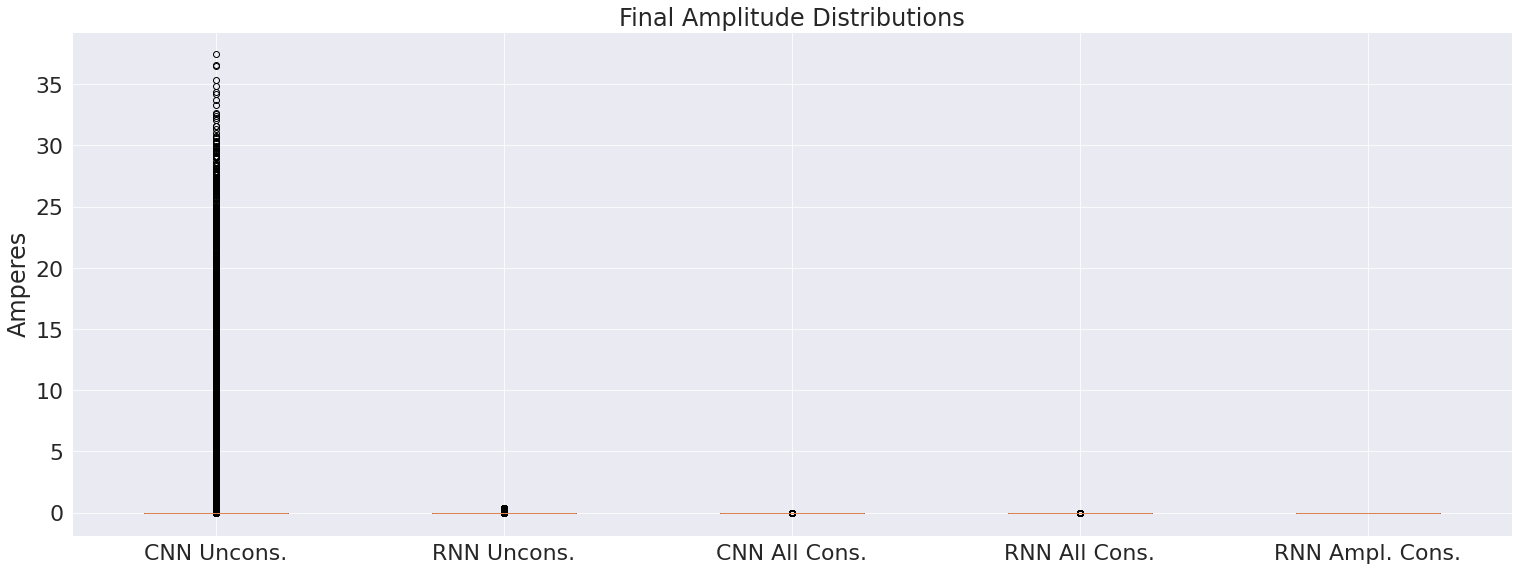

In [113]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        amplitude_cnn_uncons[-1].flatten().numpy(), 
        amplitude_rnn_uncons[-1].flatten().numpy(), 

        amplitude_cnn_cons3[-1].flatten().numpy(),
        amplitude_rnn_cons3[-1].flatten().numpy(),
        
        # amplitude_cnn_cons_amp[-1].flatten().numpy(),
        amplitude_rnn_cons_amp[-1].flatten().numpy(),

        # amplitude_cnn_cons_pw[-1].flatten().numpy(),
        # amplitude_rnn_cons_pw[-1].flatten().numpy(),

        # amplitude_cnn_cons_freq[-1].flatten().numpy(),
        # amplitude_rnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    'CNN Uncons.', 
                    'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    'RNN Ampl. Cons.',  
                #     'CNN PW Cons.', 

                #     'RNN PW Cons.', 

                #     'CNN Freq. Cons.', 
                #     'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Amplitude Distributions')
ax.set_ylabel("Amperes")
# plt.savefig('breakout_box_maxrew')
plt.show()

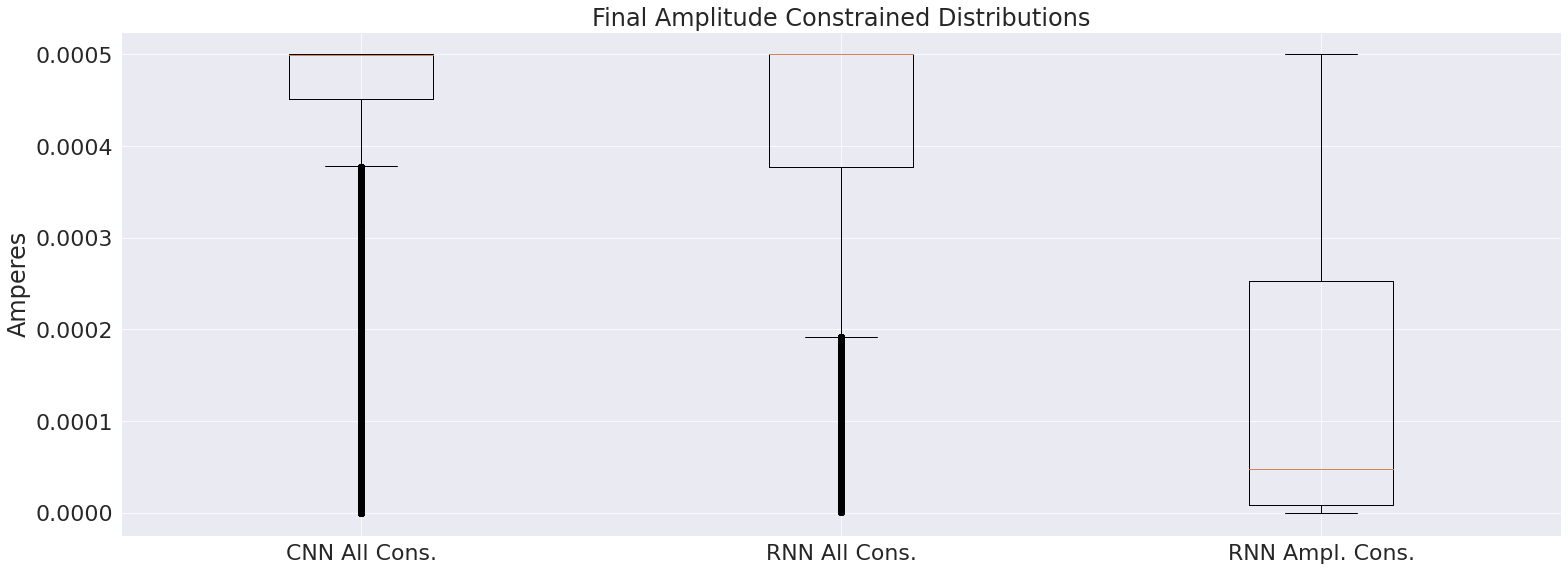

In [114]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        # amplitude_cnn_uncons[-1].flatten().numpy(), 
        # amplitude_rnn_uncons[-1].flatten().numpy(), 

        amplitude_cnn_cons3[-1].flatten().numpy(),
        amplitude_rnn_cons3[-1].flatten().numpy(),
        
        # amplitude_cnn_cons_amp[-1].flatten().numpy(),
        amplitude_rnn_cons_amp[-1].flatten().numpy(),

        # amplitude_cnn_cons_pw[-1].flatten().numpy(),
        # amplitude_rnn_cons_pw[-1].flatten().numpy(),

        # amplitude_cnn_cons_freq[-1].flatten().numpy(),
        # amplitude_rnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    # 'CNN Uncons.', 
                    # 'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    'RNN Ampl. Cons.',  
                #     'CNN PW Cons.', 

                #     'RNN PW Cons.', 

                #     'CNN Freq. Cons.', 
                #     'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Amplitude Constrained Distributions')
ax.set_ylabel("Amperes")
# plt.savefig('breakout_box_maxrew')
plt.show()

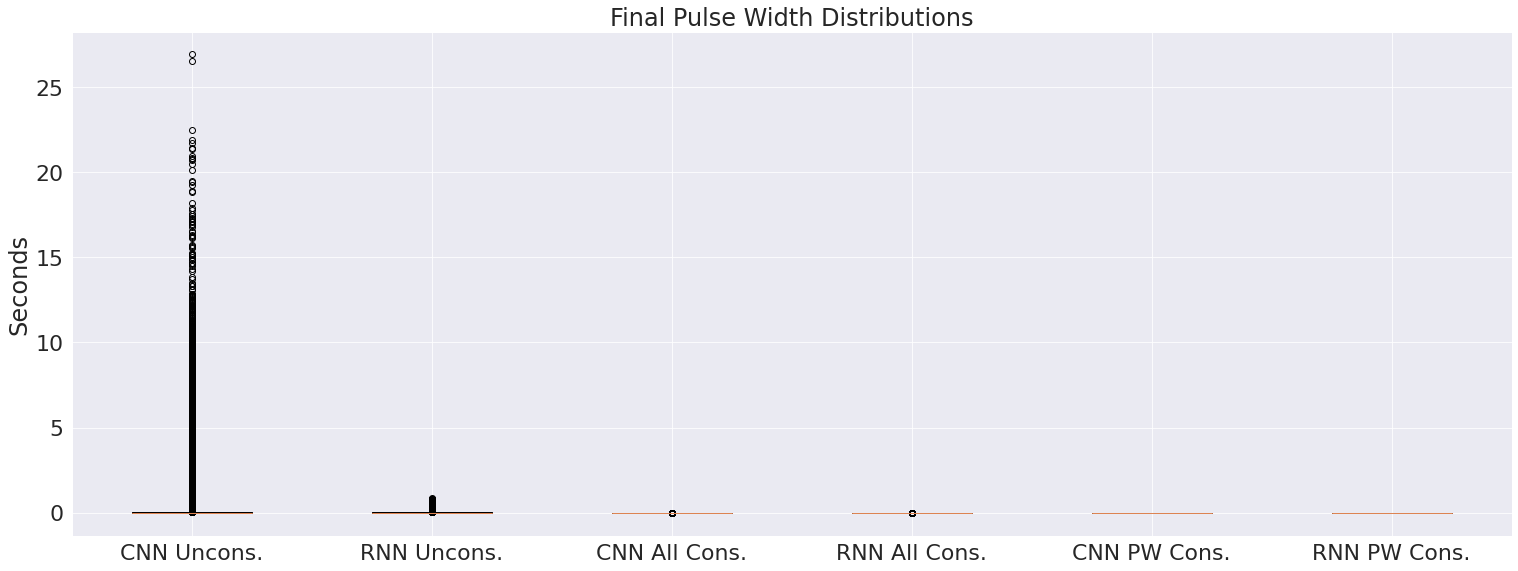

In [115]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        pw_cnn_uncons[-1].flatten().numpy(), 
        pw_rnn_uncons[-1].flatten().numpy(), 

        pw_cnn_cons3[-1].flatten().numpy(),
        pw_rnn_cons3[-1].flatten().numpy(),
        
        # pw_cnn_cons_amp[-1].flatten().numpy(),
        # pw_rnn_cons_amp[-1].flatten().numpy(),

        pw_cnn_cons_pw[-1].flatten().numpy(),
        pw_rnn_cons_pw[-1].flatten().numpy(),

        # pw_cnn_cons_freq[-1].flatten().numpy(),
        # pw_rnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    'CNN Uncons.', 
                    'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    # 'RNN Ampl. Cons.',  
                    'CNN PW Cons.', 

                    'RNN PW Cons.', 

                #     'CNN Freq. Cons.', 
                #     'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Pulse Width Distributions')
ax.set_ylabel("Seconds")
# plt.savefig('breakout_box_maxrew')
plt.show()

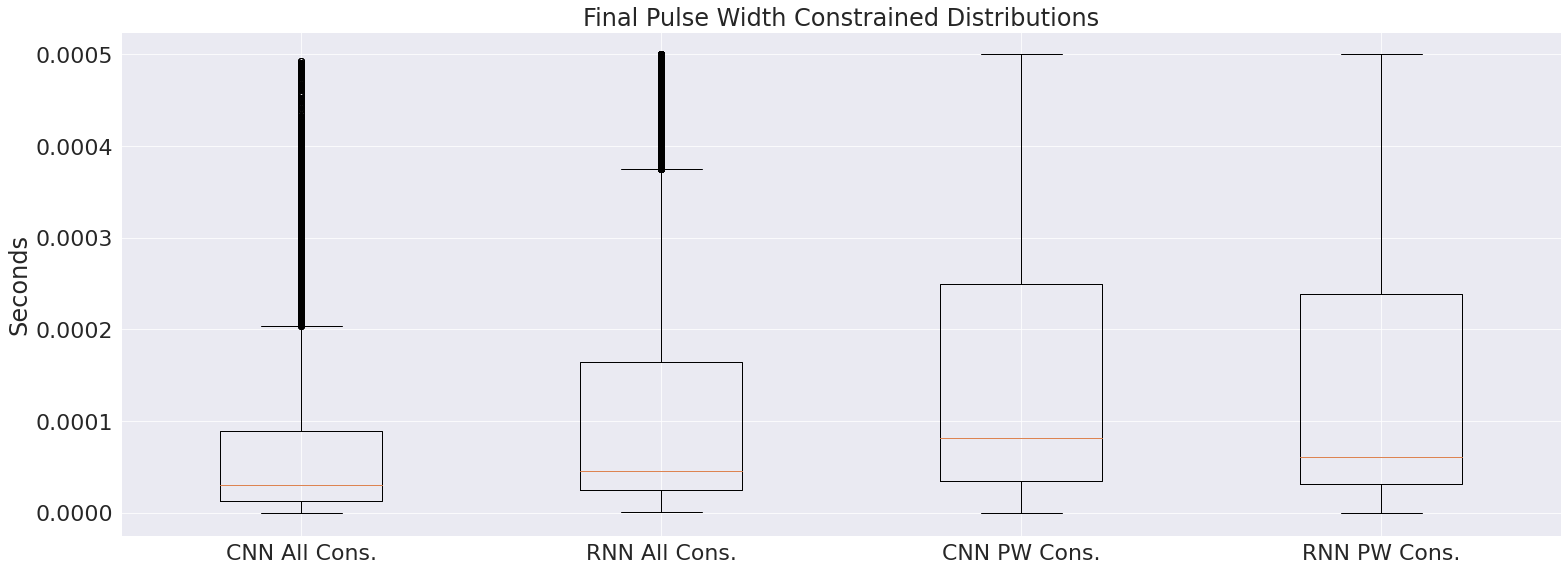

In [116]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        # pw_cnn_uncons[-1].flatten().numpy(), 
        # pw_rnn_uncons[-1].flatten().numpy(), 

        pw_cnn_cons3[-1].flatten().numpy(),
        pw_rnn_cons3[-1].flatten().numpy(),
        
        # pw_cnn_cons_amp[-1].flatten().numpy(),
        # pw_rnn_cons_amp[-1].flatten().numpy(),

        pw_cnn_cons_pw[-1].flatten().numpy(),
        pw_rnn_cons_pw[-1].flatten().numpy(),

        # pw_cnn_cons_freq[-1].flatten().numpy(),
        # pw_rnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    # 'CNN Uncons.', 
                    # 'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    # 'RNN Ampl. Cons.',  
                    'CNN PW Cons.', 

                    'RNN PW Cons.', 

                #     'CNN Freq. Cons.', 
                #     'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Pulse Width Constrained Distributions')
ax.set_ylabel("Seconds")
# plt.savefig('breakout_box_maxrew')
plt.show()

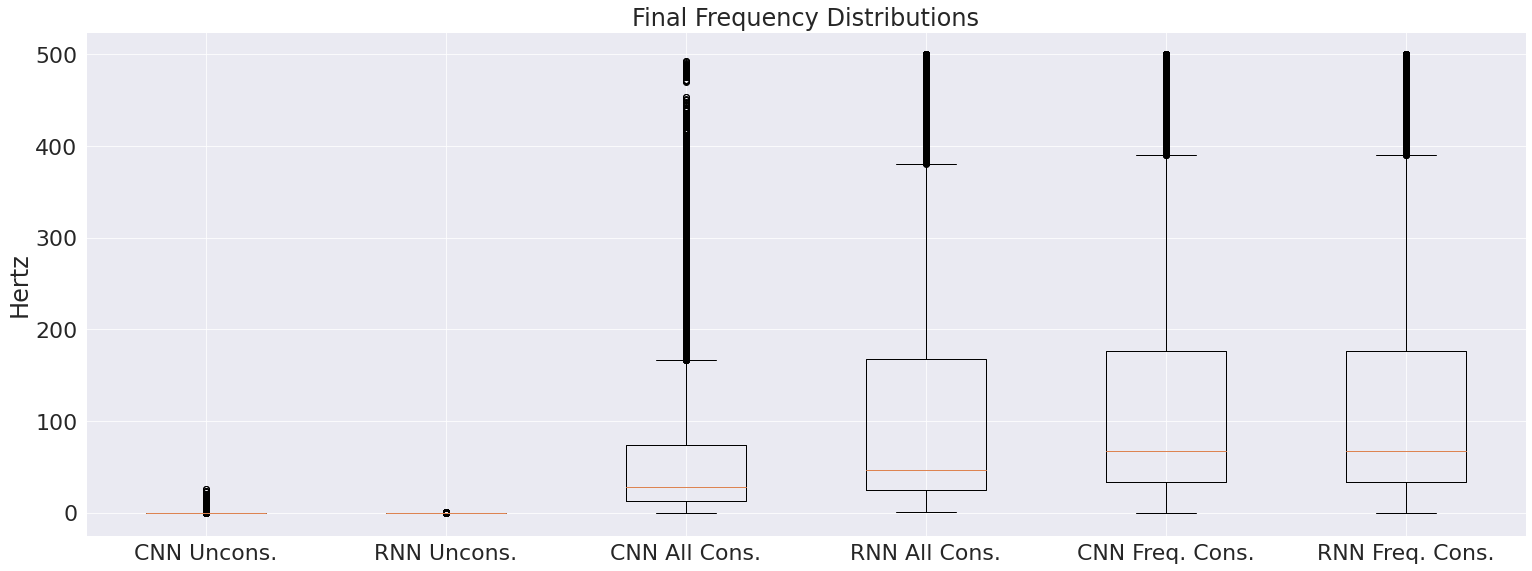

In [123]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        freq_cnn_uncons[-1].flatten().numpy(), 
        freq_rnn_uncons[-1].flatten().numpy(), 

        freq_cnn_cons3[-1].flatten().numpy(),
        freq_rnn_cons3[-1].flatten().numpy(),
        
        # freq_cnn_cons_amp[-1].flatten().numpy(),
        # freq_rnn_cons_amp[-1].flatten().numpy(),

        # freq_cnn_cons_pw[-1].flatten().numpy(),
        # freq_cnn_cons_pw[-1].flatten().numpy(),

        freq_cnn_cons_freq[-1].flatten().numpy(),
        freq_cnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    'CNN Uncons.', 
                    'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    # 'RNN Ampl. Cons.',  
                    # 'CNN PW Cons.', 

                    # 'RNN PW Cons.', 

                    'CNN Freq. Cons.', 
                    'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Frequency Distributions')
ax.set_ylabel("Hertz")
# plt.savefig('breakout_box_maxrew')
plt.show()

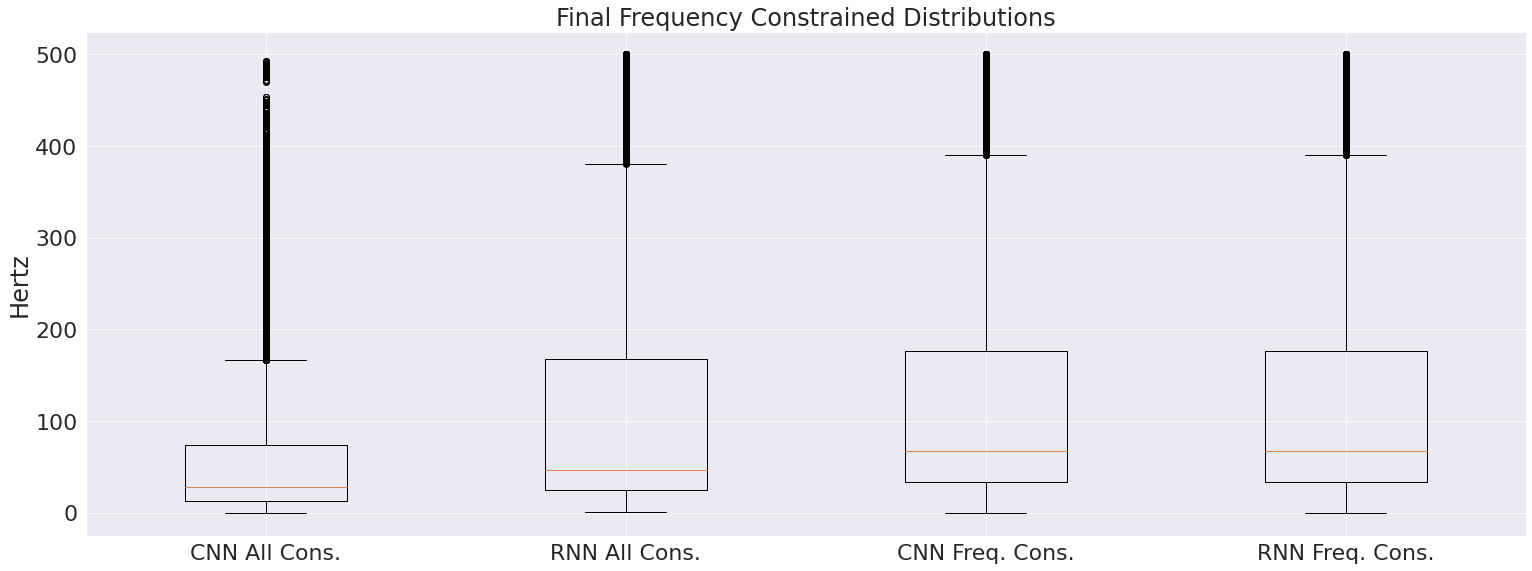

In [124]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        # freq_cnn_uncons[-1].flatten().numpy(), 
        # freq_rnn_uncons[-1].flatten().numpy(), 

        freq_cnn_cons3[-1].flatten().numpy(),
        freq_rnn_cons3[-1].flatten().numpy(),
        
        # freq_cnn_cons_amp[-1].flatten().numpy(),
        # freq_rnn_cons_amp[-1].flatten().numpy(),

        # freq_cnn_cons_pw[-1].flatten().numpy(),
        # freq_cnn_cons_pw[-1].flatten().numpy(),

        freq_cnn_cons_freq[-1].flatten().numpy(),
        freq_cnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    # 'CNN Uncons.', 
                    # 'RNN Uncons.',
                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    # 'RNN Ampl. Cons.',  
                    # 'CNN PW Cons.', 

                    # 'RNN PW Cons.', 

                    'CNN Freq. Cons.', 
                    'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Frequency Constrained Distributions')
ax.set_ylabel("Hertz")
# plt.savefig('breakout_box_maxrew')
plt.show()

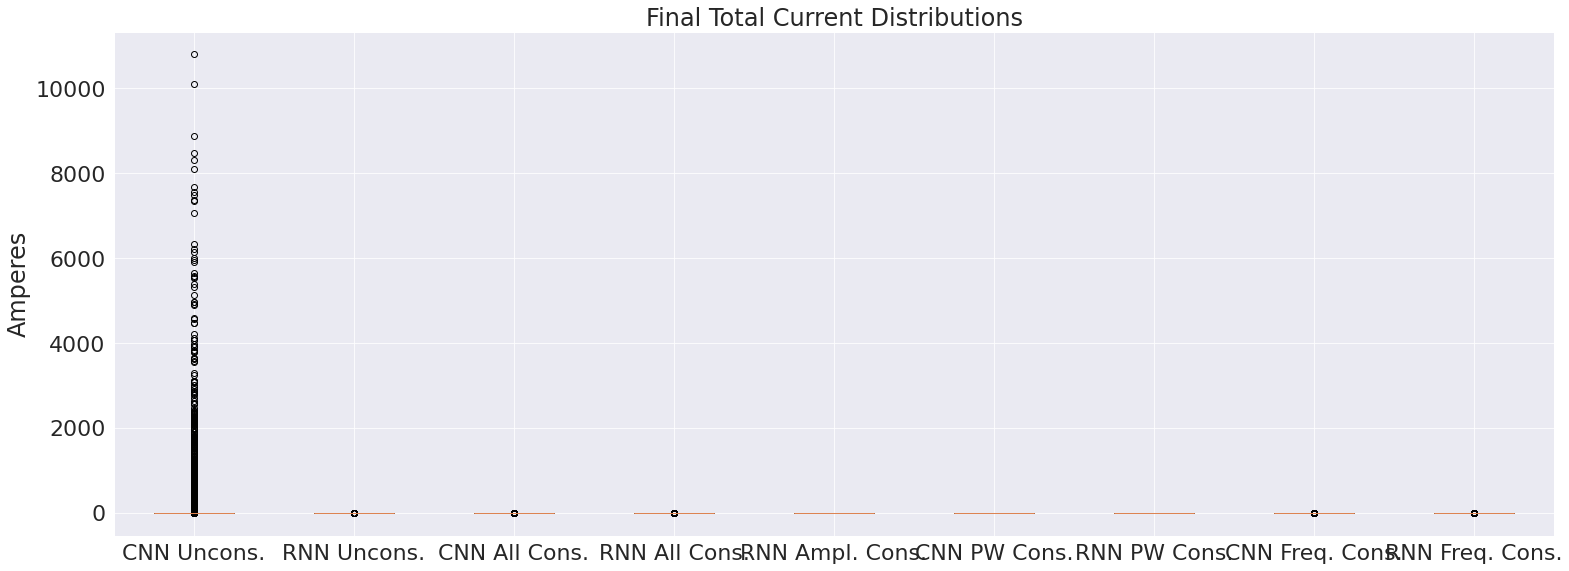

In [135]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        current_cnn_uncons[-1].flatten().numpy(), 
        current_rnn_uncons[-1].flatten().numpy(), 

        current_cnn_cons3[-1].flatten().numpy(),
        current_rnn_cons3[-1].flatten().numpy(),
        
        # current_cnn_cons_amp[-1].flatten().numpy(),
        current_rnn_cons_amp[-1].flatten().numpy(),

        current_cnn_cons_pw[-1].flatten().numpy(),
        current_cnn_cons_pw[-1].flatten().numpy(),

        current_cnn_cons_freq[-1].flatten().numpy(),
        current_cnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    'CNN Uncons.', 
                    'RNN Uncons.',

                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    'RNN Ampl. Cons.',  
                    'CNN PW Cons.', 

                    'RNN PW Cons.', 

                    'CNN Freq. Cons.', 
                    'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Total Current Distributions')
ax.set_ylabel("Amperes")
# plt.savefig('breakout_box_maxrew')
plt.show()

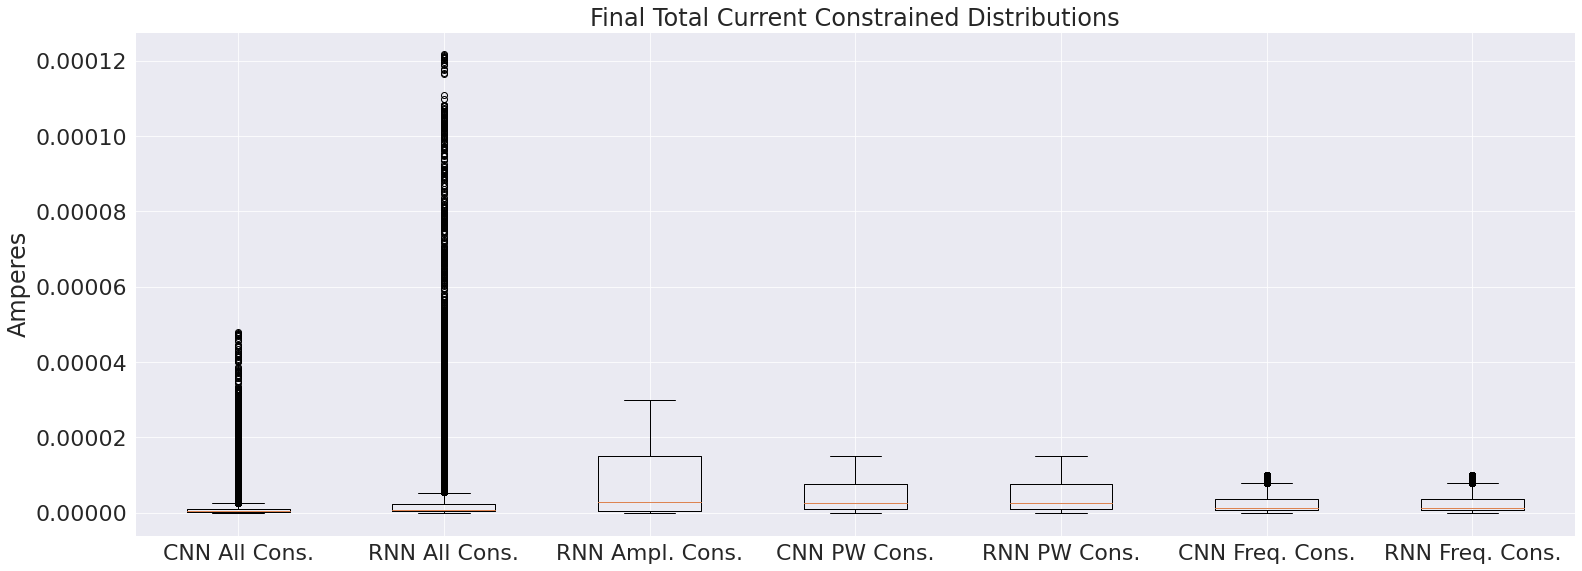

In [137]:
fig = plt.figure(figsize =(20, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])


data2=[
        # current_cnn_uncons[-1].flatten().numpy(), 
        # current_rnn_uncons[-1].flatten().numpy(), 

        current_cnn_cons3[-1].flatten().numpy(),
        current_rnn_cons3[-1].flatten().numpy(),
        
        # current_cnn_cons_amp[-1].flatten().numpy(),
        current_rnn_cons_amp[-1].flatten().numpy(),

        current_cnn_cons_pw[-1].flatten().numpy(),
        current_cnn_cons_pw[-1].flatten().numpy(),

        current_cnn_cons_freq[-1].flatten().numpy(),
        current_cnn_cons_freq[-1].flatten().numpy(),
        ]
# Creating plot
bp = ax.boxplot(data2)
ax.set_xticklabels([
                    # 'CNN Uncons.', 
                    # 'RNN Uncons.',

                    'CNN All Cons.', 
                    'RNN All Cons.',

                #     'CNN Ampl. Cons.', 

                    'RNN Ampl. Cons.',  
                    'CNN PW Cons.', 

                    'RNN PW Cons.', 

                    'CNN Freq. Cons.', 
                    'RNN Freq. Cons.'
                    ])
ax.set_title(f'Final Total Current Constrained Distributions')
ax.set_ylabel("Amperes")
# plt.savefig('breakout_box_maxrew')
plt.show()

In [52]:
#within exp loss values
fig = plt.figure(figsize =(10, 7))

df=[]
cnn_uncons_amp=pd.DataFrame({'Stimulation Parameter':['Amplitude'], 'CNN_UNCONS': transform_dict_cnn_uncons["stimulation_amplitude"][-1].flatten().numpy()})
# cnn_uncons_pw=pd.DataFrame({'Stimulation Parameter':['Pulse Width 0', 'Pulse Width 1', 'Pulse Width 3', 'Pulse Width 4'], 'CNN_UNCONS':transform_dict_cnn_uncons["stimulation_pulse_width"][-1].flatten().numpy()})
# cnn_uncons_freq=pd.DataFrame({'Stimulation Parameter':['Frequency 0', 'Frequency 1', 'Frequency 3', 'Frequency 4'], 'CNN_UNCONS':transform_dict_cnn_uncons["stimulation_pulse_width"][-1].flatten().numpy()})
# cnn_uncons_tr_reg=pd.DataFrame({'Experiment':['CNN_UNCONS 0', 'CNN_UNCONS 1', 'CNN_UNCONS 3', 'CNN_UNCONS 4'], 'Tr. Reg. Loss':data_cnn_uncons[4][0]})
# canny_avg=pd.DataFrame({'Experiment':['Canny 0', 'Canny 1', 'Canny 2', 'Canny 3', 'Canny 4'], 'Avg.':canny_reward_avg.fillna(method='ffill').iloc[-1]})
# e2e_avg=pd.DataFrame({'Experiment':['E2E 0', 'E2E 1', 'E2E 2', 'E2E 3', 'E2E 4'], 'Avg.':e2e_reward_avg.fillna(method='ffill').iloc[-1]})
# blind_avg=pd.DataFrame({'Experiment':['Blind 0', 'Blind 1', 'Blind 2', 'Blind 3', 'Blind 4'], 'Avg.':blind_reward_avg.fillna(method='ffill').iloc[-1]})

# print(normal_avg)
df_tr=pd.concat([cnn_uncons_amp]) #,cnn_uncons_tr_recon])#,cnn_uncons_tr_reg])#, canny_avg, e2e_avg, blind_avg])


rnn_uncons_amp=pd.DataFrame({'Stimulation Parameter':['Amplitude'], 'RNN_UNCONS': transform_dict_rnn_uncons["stimulation_amplitude"][-1].flatten().numpy()})
# cnn_uncons_val_recon=pd.DataFrame({'Stimulation Parameter':['CNN_UNCONS VAL 0', 'CNN_UNCONS VAL 1', 'CNN_UNCONS VAL 3', 'CNN_UNCONS VAL 4'], 'Val. Recon. Loss':data_cnn_uncons[3][0]})
# cnn_uncons_val_reg=pd.DataFrame({'Experiment':['CNN_UNCONS 0', 'CNN_UNCONS 1', 'CNN_UNCONS 3', 'CNN_UNCONS 4'], 'Val. Reg Loss':data_cnn_uncons[5][0]})

# canny_max=pd.DataFrame({'Experiment':['Canny 0', 'Canny 1', 'Canny 2', 'Canny 3', 'Canny 4'], 'Max.':canny_reward_max.fillna(method='ffill').iloc[-1]})
# e2e_max=pd.DataFrame({'Experiment':['E2E 0', 'E2E 1', 'E2E 2', 'E2E 3', 'E2E 4'], 'Max.':e2e_reward_max.fillna(method='ffill').iloc[-1]})
# blind_max=pd.DataFrame({'Experiment':['Blind 0', 'Blind 1', 'Blind 2', 'Blind 3', 'Blind 4'], 'Max.':blind_reward_max.fillna(method='ffill').iloc[-1]})

df_val=pd.concat([rnn_uncons_amp])#,cnn_uncons_val_reg])#, canny_max, e2e_max, blind_max])


df=df_tr.join(df_val.set_index('Experiment'), on='Experiment')
df['Experiment']=df['Experiment'].apply(lambda x: x.split(' ')[0])

print(df)

NameError: name 'transform_dict_cnn_uncons' is not defined

<Figure size 720x504 with 0 Axes>

In [21]:
transform_dict_rnn_uncons = load_transform(directory, "RNN_UNCONS", exp_dir, seed=1)

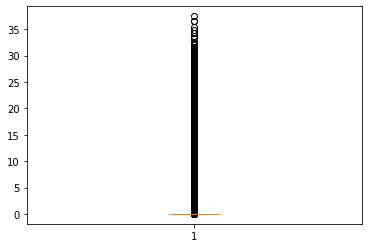

In [19]:
plt.boxplot(transform_dict_cnn_uncons["stimulation_amplitude"][-1].flatten().numpy())
plt.xlabel()
plt.show()

In [82]:
exp_dir

{'CNN_UNCONS': ['kitty_zhao_sig_fps10_nomax_out3_uncons_s0',
  'kitty_zhao_sig_fps10_nomax_out3_uncons_s1',
  'kitty_zhao_sig_fps10_nomax_out3_uncons_s2',
  'kitty_zhao_sig_fps10_nomax_out3_uncons_s3',
  'kitty_zhao_sig_fps10_nomax_out3_uncons_s4'],
 'RNN_UNCONS': ['kitty_zhao_sig_fps10_rnn_nomax_out3_uncons',
  'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s1',
  'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s2',
  'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s3',
  'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_uncons_s4'],
 'CNN_CONS_ONFR2': ['kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s0',
  'kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s1',
  'kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s2',
  'kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s3',
  'kitty_zhao_sig_fps10_nomax_out3_allcons2onfr_coef2_s4'],
 'RNN_CONS_ONFR2': ['kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_allcons2onfr_coef2_s0',
  'kitty_zhao_sig_fps10_sliding_rnn_nomax_out3_a

In [85]:
directory

'/home/burkuc/data/v_dy/'

In [87]:
exp_transform_dict


{'CNN_UNCONS': {},
 'RNN_UNCONS': {},
 'CNN_CONS_ONFR2': {},
 'RNN_CONS_ONFR2': {},
 'CNN_CONS1_AMP': {},
 'RNN_CONS1_AMP': {},
 'CNN_CONS1_PW': {},
 'RNN_CONS1_PW': {},
 'CNN_CONS1_FREQ': {},
 'RNN_CONS1_FREQ': {}}